# Running HDBSCAN on different combinations of abundances

In [3]:
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.table import Table, join, Column
from sklearn.cluster import HDBSCAN
from sklearn.preprocessing import StandardScaler

In [4]:
galah = Table.read("/Users/chloerenard-robins/Downloads/galahdr3_solartwins.fits")

In [5]:
galah

B1,GaiaDR3,GALAHDR3,chisq,Teff,e_Teff,logg,e_logg,__Fe_H_,e__Fe_H_,__Na_Fe_,e__Na_Fe_,__Mg_Fe_,e__Mg_Fe_,__Al_Fe_,e__Al_Fe_,__Si_Fe_,e__Si_Fe_,__Ca_Fe_,e__Ca_Fe_,__Sc_Fe_,e__Sc_Fe_,__Ti_Fe_,e__Ti_Fe_,__Cr_Fe_,e__Cr_Fe_,__Mn_Fe_,e__Mn_Fe_,__Ni_Fe_,e__Ni_Fe_,__Cu_Fe_,e__Cu_Fe_,__Zn_Fe_,e__Zn_Fe_,__Y_Fe_,e__Y_Fe_,__Ba_Fe_,e__Ba_Fe_,_RA,_DE
,,,,K,K,log(cm.s**-2),log(cm.s**-2),,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,deg,deg
bytes1,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
,4667351131045805696,131116000501046,1.9683584552237479,5889.62544041529,2.6594471837721207,4.279342566228304,0.0052274862381448736,-0.1908619518597763,0.0022989503378323113,0.021794758361215635,0.013141754569581117,0.015859471970213628,0.019360047776215816,0.13599628469118102,0.05785360203527981,0.0234304376110103,0.01053884796966398,-0.0771297787181646,0.007834597995057833,0.037598113153134376,0.011475672960494988,0.02715747606568709,0.00846677746927224,-0.11095585771427387,0.017019314851524924,-0.09377365856608359,0.01140576264083877,-0.03914038796383523,0.023641714672529558,0.03962369454058494,0.049961332080241894,-0.09254401049791307,0.028241935498623773,-0.045579667003827436,0.04835182832565971,-0.13459879345492368,0.024820568356147526,53.75001,-68.87582
,4667188441980796288,131116000501067,2.9761184687097946,5692.609630276435,3.2858223605747283,4.336541717878018,0.0059588668691114175,0.2594395162221509,0.0025050952571442466,0.07682749005889276,0.017895841352783864,0.05433808400564968,0.02821054461677296,0.166663958520463,0.022013490630466537,0.012288070484913103,0.010075786198704462,-0.0701964333038555,0.007704498887280094,-0.026334642220089882,0.012636221625590258,-0.023490191148418747,0.011090631418219168,0.06591421839619856,0.017988609815431513,0.01602730720982494,0.022906950135529673,0.048514564881318396,0.011818217781438357,0.18003625199742432,0.02283905269384365,-0.003648970891599024,0.04556682685889757,-0.2441158293672552,0.046606033070133016,-0.24542937163565853,0.020752077283881967,54.17993,-69.32717
,4667204728496771840,131116000501080,9.186335558648214,5861.92896075486,5.3194866797824965,4.3027754886676846,0.010520066658530903,-0.13529243081407918,0.004614014983469746,0.016932881807850138,0.0258562766052444,0.057870630904388654,0.039771094749967276,-0.013940786430621493,0.061955080601659364,0.04851451415802373,0.0201539542334176,0.17860734031370093,0.011712252924341988,0.04843212175667991,0.026797051374456274,-0.02251774052372589,0.01717736190913904,-0.043221993246619746,0.031205502550984372,-0.1888837384862923,0.023523363588875208,0.0693624405653659,0.03801667466220268,-0.0010162194687179968,0.07718281368680625,-0.10639923609432907,0.0678160956744482,-0.0748902060656474,0.11203007848579608,-0.034966443211136226,0.051067078688740046,53.5362,-69.16452
,4667257676853593600,131116000501081,5.84508435603436,5685.26967985336,3.61519069841664,4.2408411651236015,0.006387393370668119,-0.19771494918523047,0.0032021068318344764,0.05989798031593038,0.01934745687678882,0.1670527828411471,0.03406147002295437,0.310983145074122,0.06194216536919378,0.10029639708544412,0.015846647200961867,-0.07328658926908041,0.008769003572517343,0.14122413689689814,0.021835983218378336,0.16964478783590245,0.012168654406190535,-0.03725368432828794,0.020124168652671384,-0.1636485360434919,0.020713346664769067,0.019875937405504616,0.025091449322303585,0.07486407521766916,0.05603490487412233,-0.017243187917871022,0.058491499592443666,-0.38508210615361843,0.050199415447893504,-0.17489510887522391,0.02784374097166801,53.3233,-69.02462
,4667271558187890304,131116000501102,4.8056203115224925,5805.468405177111,4.104970120821855,4.413881616771254,0.004577700916224789,-0.18238732179948622,0.0034885836301430124,-0.06578940163322995,0.0170

In [9]:
galah_renamed = galah.copy()
galah_renamed.rename_column('GALAHDR3', 'sobject_id')

In [11]:
good = np.where((galah_renamed['e__Fe_H_'] <= 0.05) & (galah_renamed['e__Mn_Fe_'] <= 0.05) & (galah_renamed['e__Mg_Fe_'] <= 0.05) & (galah_renamed['e__Al_Fe_'] <= 0.05)
     & (galah_renamed['e__Ba_Fe_'] <= 0.05) & (galah_renamed['e__Y_Fe_'] <= 0.05) & (galah_renamed['__Fe_H_'] > -.5))
# & (galah_renamed['flag_Mn_fe'] == 0)  & (galah_renamed['flag_Nd_fe'] == 0) & (galah_renamed['flag_Eu_fe'] == 0) & (galah_renamed['flag_La_fe'] == 0) 
# we select the lines from the data table where the flags for certain concentrations is 0
print(good)

(array([    1,    13,    17, ..., 38316, 38317, 38318]),)


In [13]:
galah_dynamics = Table.read("/Users/chloerenard-robins/Downloads/GALAH_DR3_VAC_dynamics_v2.fits")

In [15]:
galah_dynamics

sobject_id,use_dist_flag,use_rv_flag,X_XYZ,Y_XYZ,Z_XYZ,U_UVW,V_UVW,W_UVW,R_Rzphi,phi_Rzphi,z_Rzphi,vR_Rzphi,vT_Rzphi,vz_Rzphi,J_R,L_Z,J_Z,omega_R,omega_phi,omega_z,angle_R,angle_phi,angle_z,ecc,zmax,R_peri,R_ap,Energy,X_XYZ_5,X_XYZ_50,X_XYZ_95,Y_XYZ_5,Y_XYZ_50,Y_XYZ_95,Z_XYZ_5,Z_XYZ_50,Z_XYZ_95,U_UVW_5,U_UVW_50,U_UVW_95,V_UVW_5,V_UVW_50,V_UVW_95,W_UVW_5,W_UVW_50,W_UVW_95,R_Rzphi_5,R_Rzphi_50,R_Rzphi_95,phi_Rzphi_5,phi_Rzphi_50,phi_Rzphi_95,z_Rzphi_5,z_Rzphi_50,z_Rzphi_95,vR_Rzphi_5,vR_Rzphi_50,vR_Rzphi_95,vT_Rzphi_5,vT_Rzphi_50,vT_Rzphi_95,vz_Rzphi_5,vz_Rzphi_50,vz_Rzphi_95,J_R_5,J_R_50,J_R_95,L_Z_5,L_Z_50,L_Z_95,J_Z_5,J_Z_50,J_Z_95,omega_R_5,omega_R_50,omega_R_95,omega_phi_5,omega_phi_50,omega_phi_95,omega_z_5,omega_z_50,omega_z_95,angle_R_5,angle_R_50,angle_R_95,angle_phi_5,angle_phi_50,angle_phi_95,angle_z_5,angle_z_50,angle_z_95,ecc_5,ecc_50,ecc_95,zmax_5,zmax_50,zmax_95,R_peri_5,R_peri_50,R_peri_95,R_ap_5,R_ap_50,R_ap_95,Energy_5,Energy_50,Energy_95
,,,kpc,kpc,kpc,km / s,km / s,km / s,kpc,rad,kpc,km / s,km / s,km / s,km kpc / s,km kpc / s,km kpc / s,1 / Gyr,1 / Gyr,1 / Gyr,rad,rad,rad,,kpc,kpc,kpc,1 / (km2 s2),kpc,kpc,kpc,kpc,kpc,kpc,kpc,kpc,kpc,km / s,km / s,km / s,km / s,km / s,km / s,km / s,km / s,km / s,kpc,kpc,kpc,rad,rad,rad,kpc,kpc,kpc,km / s,km / s,km / s,km / s,km / s,km / s,km / s,km / s,km / s,km kpc / s,km kpc / s,km kpc / s,km kpc / s,km kpc / s,km kpc / s,km kpc / s,km kpc / s,km kpc / s,1 / Gyr,1 / Gyr,1 / Gyr,1 / Gyr,1 / Gyr,1 / Gyr,1 / Gyr,1 / Gyr,1 / Gyr,rad,rad,rad,rad,rad,rad,rad,rad,rad,,,,kpc,kpc,kpc,kpc,kpc,kpc,kpc,kpc,kpc,1 / (km2 s2),1 / (km2 s2),1 / (km2 s2)
int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
131116000501002,0,0,0.026328794151845674,-0.10251971338643251,-0.09588676007223906,-74.85739790692249,-70.0943466924733,0.46372343130329396,8.184605367231821,-0.012526233518573234,-0.07096660111613959,61.518891181852574,178.96034194505432,7.941456114842559,98.3776797597503,1464.7197752051338,0.6744433459305317,49.70320105282431,33.90872356138757,97.3638670979235,2.1249264246792827,5.990199100441617,5.1138291631999335,0.2918456489348003,0.1466968623318004,4.8449787324905165,8.83841875056594,-165908.63522577734,0.026261995741936852,0.026329700719548717,0.026389812973824655,-0.10275730984233361,-0.10252324767442506,-0.10225962575106957,-0.09610898417237226,-0.09589006660395946,-0.09564350284568698,-75.06668290154711,-74.86241434880499,-74.64590063086276,-70.31842138448714,-70.09344029719477,-69.84483937734035,0.2495488623676074,0.469550777612312,0.6728566651997708,8.184548009592216,8.184604515076696,8.184668165852514,-0.012555353438657782,-0.012526666677701023,-0.012494357532859565,-0.07118901025347696,-0.07096991039697483,-0.07072314132595564,61.311153690096305,61.5234466773216,61.723554111809115,178.7387869564471,178.96068018897975,179.2100548641424,7.726733189899178,7.94710487103244,8.151254373158892,97.7928714270848,98.3768639326627,98.90598445532916,1462.8982069598933,1464.7255503832369,1466.7676843611187,0.6491489482487538,0.6749486198395449,0.7007064180508606,49.65749761733111,49.70331948220881,49.74370943450479,33.882940335408236,33.908608715133354,33.93205993607963,97.04497606862994,97.3604822397657,97.

In [73]:
galah_dynamics_df = galah_dynamics.to_pandas()
col = "zmax"

# convert & filter
vals = pd.to_numeric(galah_dynamics_df[col], errors='coerce')      # floats or nan
vals = vals[np.isfinite(vals)]                      # remove nan & inf

#print(len(vals), "finite values")

# sanity check — this should always print False
#print("any infinite left:", np.isinf(vals).any())



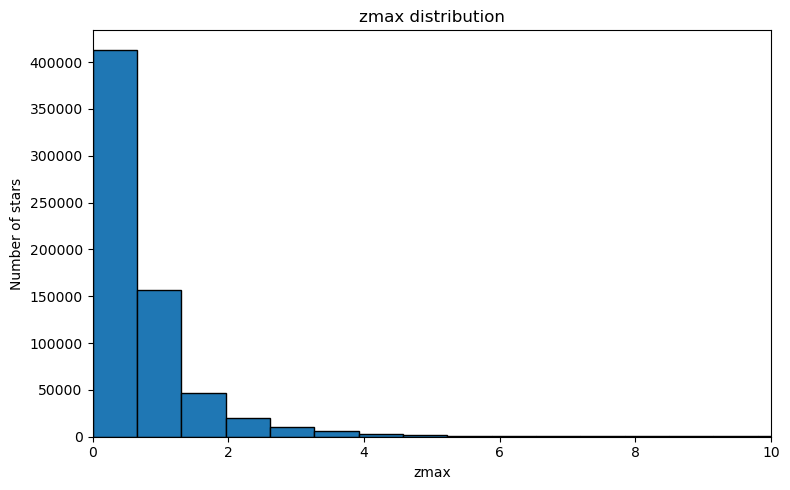

In [75]:
plt.figure(figsize=(8,5))
plt.hist(vals, bins=500, edgecolor='black')
plt.xlabel(col)
plt.ylabel("Number of stars")
plt.title(f"{col} distribution")
plt.xlim(0, 10)
plt.tight_layout()
plt.show()

In [77]:
J_phi_limit = 1700

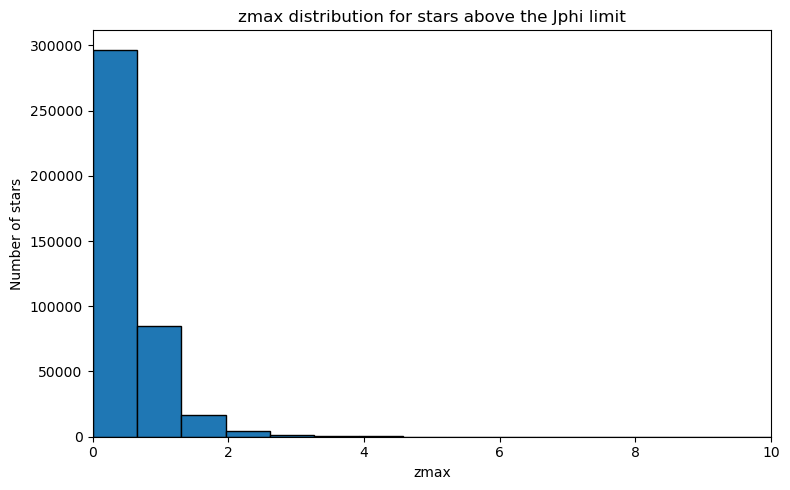

In [85]:
galah_dynamics_df = galah_dynamics.to_pandas()
col = "zmax"
filter_col = "L_Z"  # the thing you want to threshold

limit = J_phi_limit     # whatever threshold you want

# convert both columns to numeric
galah_dynamics_df[col]     = pd.to_numeric(galah_dynamics_df[col], errors='coerce')
galah_dynamics_df[filter_col] = pd.to_numeric(galah_dynamics_df[filter_col], errors='coerce')

# filter: keep only rows where L_z is finite AND > limit
mask = (np.isfinite(galah_dynamics_df[filter_col])) & (abs(galah_dynamics_df[filter_col] > limit))

vals = galah_dynamics_df.loc[mask, col]

# remove any bad z values
vals = vals[np.isfinite(vals)]                  # remove nan & inf

#print(len(vals), "finite values")

# sanity check — this should always print False
#print("any infinite left:", np.isinf(vals).any())

plt.figure(figsize=(8,5))
plt.hist(vals, bins=500, edgecolor='black')
plt.xlabel(col)
plt.ylabel("Number of stars")
plt.title(f"{col} distribution for stars above the Jphi limit")
plt.xlim(0, 10)
plt.tight_layout()
plt.show()

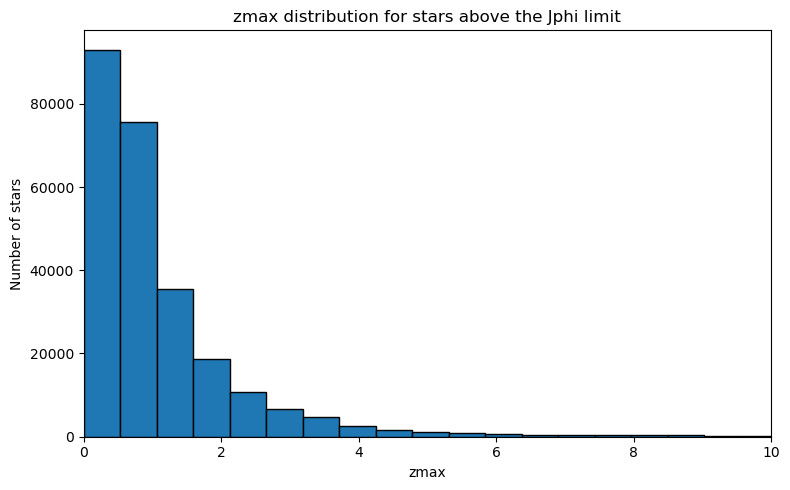

In [83]:
galah_dynamics_df = galah_dynamics.to_pandas()
col = "zmax"
filter_col = "L_Z"  # the thing you want to threshold

limit = J_phi_limit     # whatever threshold you want

# convert both columns to numeric
galah_dynamics_df[col]     = pd.to_numeric(galah_dynamics_df[col], errors='coerce')
galah_dynamics_df[filter_col] = pd.to_numeric(galah_dynamics_df[filter_col], errors='coerce')

# filter: keep only rows where L_z is finite AND > limit
mask = (np.isfinite(galah_dynamics_df[filter_col])) & (abs(galah_dynamics_df[filter_col] < limit))

vals = galah_dynamics_df.loc[mask, col]

# remove any bad z values
vals = vals[np.isfinite(vals)]                  # remove nan & inf

#print(len(vals), "finite values")

# sanity check — this should always print False
#print("any infinite left:", np.isinf(vals).any())

plt.figure(figsize=(8,5))
plt.hist(vals, bins=500, edgecolor='black')
plt.xlabel(col)
plt.ylabel("Number of stars")
plt.title(f"{col} distribution for stars above the Jphi limit")
plt.xlim(0, 10)
plt.tight_layout()
plt.show()

#### joining the spectroscopic and dynamical data

In [60]:
# joins the HDBSCAN output table and the dynamics table by identifying the cluster by its Apogee ID
spectroscopy_dynamics_joined = join (galah_renamed[good],galah_dynamics, keys='sobject_id', join_type='inner') 

In [62]:
spectroscopy_dynamics_joined

B1,GaiaDR3,sobject_id,chisq,Teff,e_Teff,logg,e_logg,__Fe_H_,e__Fe_H_,__Na_Fe_,e__Na_Fe_,__Mg_Fe_,e__Mg_Fe_,__Al_Fe_,e__Al_Fe_,__Si_Fe_,e__Si_Fe_,__Ca_Fe_,e__Ca_Fe_,__Sc_Fe_,e__Sc_Fe_,__Ti_Fe_,e__Ti_Fe_,__Cr_Fe_,e__Cr_Fe_,__Mn_Fe_,e__Mn_Fe_,__Ni_Fe_,e__Ni_Fe_,__Cu_Fe_,e__Cu_Fe_,__Zn_Fe_,e__Zn_Fe_,__Y_Fe_,e__Y_Fe_,__Ba_Fe_,e__Ba_Fe_,_RA,_DE,use_dist_flag,use_rv_flag,X_XYZ,Y_XYZ,Z_XYZ,U_UVW,V_UVW,W_UVW,R_Rzphi,phi_Rzphi,z_Rzphi,vR_Rzphi,vT_Rzphi,vz_Rzphi,J_R,L_Z,J_Z,omega_R,omega_phi,omega_z,angle_R,angle_phi,angle_z,ecc,zmax,R_peri,R_ap,Energy,X_XYZ_5,X_XYZ_50,X_XYZ_95,Y_XYZ_5,Y_XYZ_50,Y_XYZ_95,Z_XYZ_5,Z_XYZ_50,Z_XYZ_95,U_UVW_5,U_UVW_50,U_UVW_95,V_UVW_5,V_UVW_50,V_UVW_95,W_UVW_5,W_UVW_50,W_UVW_95,R_Rzphi_5,R_Rzphi_50,R_Rzphi_95,phi_Rzphi_5,phi_Rzphi_50,phi_Rzphi_95,z_Rzphi_5,z_Rzphi_50,z_Rzphi_95,vR_Rzphi_5,vR_Rzphi_50,vR_Rzphi_95,vT_Rzphi_5,vT_Rzphi_50,vT_Rzphi_95,vz_Rzphi_5,vz_Rzphi_50,vz_Rzphi_95,J_R_5,J_R_50,J_R_95,L_Z_5,L_Z_50,L_Z_95,J_Z_5,J_Z_50,J_Z_95,omega_R_5,omega_R_50,omega_R_95,omega_phi_5,omega_phi_50,omega_phi_95,omega_z_5,omega_z_50,omega_z_95,angle_R_5,angle_R_50,angle_R_95,angle_phi_5,angle_phi_50,angle_phi_95,angle_z_5,angle_z_50,angle_z_95,ecc_5,ecc_50,ecc_95,zmax_5,zmax_50,zmax_95,R_peri_5,R_peri_50,R_peri_95,R_ap_5,R_ap_50,R_ap_95,Energy_5,Energy_50,Energy_95
,,,,K,K,log(cm.s**-2),log(cm.s**-2),,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,deg,deg,,,kpc,kpc,kpc,km / s,km / s,km / s,kpc,rad,kpc,km / s,km / s,km / s,km kpc / s,km kpc / s,km kpc / s,1 / Gyr,1 / Gyr,1 / Gyr,rad,rad,rad,,kpc,kpc,kpc,1 / (km2 s2),kpc,kpc,kpc,kpc,kpc,kpc,kpc,kpc,kpc,km / s,km / s,km / s,km / s,km / s,km / s,km / s,km / s,km / s,kpc,kpc,kpc,rad,rad,rad,kpc,kpc,kpc,km / s,km / s,km / s,km / s,km / s,km / s,km / s,km / s,km / s,km kpc / s,km kpc / s,km kpc / s,km kpc / s,km kpc / s,km kpc / s,km kpc / s,km kpc / s,km kpc / s,1 / Gyr,1 / Gyr,1 / Gyr,1 / Gyr,1 / Gyr,1 / Gyr,1 / Gyr,1 / Gyr,1 / Gyr,rad,rad,rad,rad,rad,rad,rad,rad,rad,,,,kpc,kpc,kpc,kpc,kpc,kpc,kpc,kpc,kpc,1 / (km2 s2),1 / (km2 s2),1 / (km2 s2)
bytes1,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
,4667188441980796288,131116000501067,2.9761184687097946,5692.609630276435,3.2858223605747283,4.336541717878018,0.0059588668691114175,0.2594395162221509,0.0025050952571442466,0.07682749005889276,0.017895841352783864,0.05433808400564968,0.02821054461677296,0.166663958520463,0.022013490630466537,0.012288070484913103,0.010075786198704462,-0.0701964333038555,0.007704498887280094,-0.026334642220089882,0.012636221625590258,-0.023490191148418747,0.011090631418219168,0.06591421839619856,0.017988609815431513,0.01602730720982494,0.022906950135529673,0.048514564881318396,0.011818217781438357,0.18003625199742432,0.02283905269384365,-0.003648970891599024,0.04556682685889757,-0.2441158293672552,0.046606033070133016,-0.24542937163565853,0.020752077283881967,54.17993,-69.32717,0,0,0.054995066678557906,-0.20815821347146335,-0.19

#### running HDBSCAN and dynamical spread analysis on different combinations of abundances

In [64]:
galah_table_chunk_going_into_hdbscan = spectroscopy_dynamics_joined['__Fe_H_','__Mn_Fe_', '__Mg_Fe_', '__Al_Fe_','__Ba_Fe_', '__Y_Fe_'] #'La_fe', 'Nd_fe','Eu_fe']
abund_cols = ['__Fe_H_','__Mn_Fe_', '__Mg_Fe_', '__Al_Fe_','__Ba_Fe_', '__Y_Fe_'] #'La_fe', 'Nd_fe','Eu_fe'] # creates a list of the columns of abundances that will be used
label_col  = 'HDBSCAN_Cluster' # creates a column for the cluster group 
df = galah_table_chunk_going_into_hdbscan.to_pandas().astype('float64')  # transforms table of columns that will run through HDBSCAN into a DataFrame

In [66]:
# creates a list of all of the different possible combinations of the seven abundances used
combos = (
    list(itertools.combinations(abund_cols, 2)) +  # all 2‑D combinations
    list(itertools.combinations(abund_cols, 3)) +  # all 3‑D combinations
    list(itertools.combinations(abund_cols, 4)) +  # all 4‑D combinations
    list(itertools.combinations(abund_cols, 5)) +  # all 5‑D combinations
    list(itertools.combinations(abund_cols, 6))    # all 6‑D combinations
)

In [68]:
mcs = 3 #this is what the other paper said
maxcs = 1222 # arbitrary
cse = 0.02

In [70]:
clusterers = {}  # creates a dictionary to hold each fitted HDBSCAN model 
cluster_labels_dict = {}  # creates a dictrionary to hold all new columns
spread_cols = ['Energy', 'ecc', 'zmax', 'J_R', 'J_Z', 'L_Z'] # creates a list of the columns that will be used to calculate spread
spread_results = {} # creates a dictionary to hold the calculated results of the spreads

df_abund = galah_table_chunk_going_into_hdbscan.to_pandas().astype('float64') # abundance DataFrame (used for clustering)

# dynamical DataFrame (used for spread analysis)
df_dyn = pd.DataFrame(
    {col: np.asarray(spectroscopy_dynamics_joined[col], dtype='float64') # turns each column into a numpy array and assigns each array to its corresponding key
     for col in spread_cols}, # loops through each column in spread_cols  
    index=np.arange(len(spectroscopy_dynamics_joined)) # ensures that the DataFrame has the same length as the astropy table
)
df_dyn['sobject_id'] = spectroscopy_dynamics_joined['sobject_id'] # adds a column to the DataaFrame for apogee id


for combo in combos: # loops over each tuple of abundances
    tag = '|'.join(combo) # joins the different abundances into a name with abundances seperated by |
    features = df_abund[list(combo)].to_numpy() # pulls only the relevent columns from df and turns it into a numpy array
    hdb = HDBSCAN(min_cluster_size=mcs, cluster_selection_epsilon = cse, max_cluster_size= maxcs) # configures a new HDBSCAN instance
    hdb.fit(features) # runs HDBSCAN
    labels = hdb.labels_.astype(int) 
    clusterers[tag] = hdb # saves the fitted model into the clusterers dictionary
    cluster_labels_dict[f'cluster_{tag}'] = labels # stores labels in the column dictionary
    dyn_tmp = df_dyn.copy() # compute average cluster size
    dyn_tmp['HDBSCAN_Cluster'] = labels # Merge cluster labels with dynamical data
    dyn_good = dyn_tmp[~dyn_tmp['HDBSCAN_Cluster'].isin([-1, -3])] # remove noise and outliers
    spread = dyn_good.groupby('HDBSCAN_Cluster')[spread_cols].std() # compute spread within each cluster
    spread_results[tag] = spread.mean()  # average spread per dynamical variable
cluster_df = pd.DataFrame(cluster_labels_dict, index=df.index) # creates a dataframe with every key in cluster_labels_dict as a column and the same index as df
df = pd.concat([df, cluster_df], axis=1) # attaches all new cluster columns to the main DataFrame
spread_summary = pd.DataFrame(spread_results).T  # rows = tags, cols = variables
spread_summary.reset_index(inplace=True)
spread_summary.rename(columns={'index': 'combo_tag'}, inplace=True)
spread_table = Table.from_pandas(spread_summary)

In [72]:
cluster_counts = {} # creates an empty dictionary that will map combo tag to the number of clusters

for tag in clusterers.keys(): # iterates over every abundance combo
    col = f'cluster_{tag}' # builds the dataframe column name
    unique_labels = pd.unique(df[col].values.ravel()) # grabs all the distinct label values that represent seperate clusters in that column 
    n_clusters = len(unique_labels[unique_labels >= 0])  # ignores all the values that are negative (-1 is noise)
    cluster_counts[tag] = n_clusters # saves the count of clusters to a dictionary

print("Clusters found per combo:")
for tag, n in cluster_counts.items(): # iterates over the dictionary
    print(f"{tag:<30}  {n:3d}") # prints the tags is a readable format (left aligns the tag in a 30 character field and shows the number of clusters as a three digit integer)

Clusters found per combo:
__Fe_H_|__Mn_Fe_                  5
__Fe_H_|__Mg_Fe_                  6
__Fe_H_|__Al_Fe_                  5
__Fe_H_|__Ba_Fe_                  6
__Fe_H_|__Y_Fe_                  21
__Mn_Fe_|__Mg_Fe_                 8
__Mn_Fe_|__Al_Fe_                 2
__Mn_Fe_|__Ba_Fe_                 5
__Mn_Fe_|__Y_Fe_                  9
__Mg_Fe_|__Al_Fe_                 6
__Mg_Fe_|__Ba_Fe_                 9
__Mg_Fe_|__Y_Fe_                 12
__Al_Fe_|__Ba_Fe_                13
__Al_Fe_|__Y_Fe_                 17
__Ba_Fe_|__Y_Fe_                 24
__Fe_H_|__Mn_Fe_|__Mg_Fe_        48
__Fe_H_|__Mn_Fe_|__Al_Fe_        65
__Fe_H_|__Mn_Fe_|__Ba_Fe_        64
__Fe_H_|__Mn_Fe_|__Y_Fe_         80
__Fe_H_|__Mg_Fe_|__Al_Fe_        78
__Fe_H_|__Mg_Fe_|__Ba_Fe_       134
__Fe_H_|__Mg_Fe_|__Y_Fe_        111
__Fe_H_|__Al_Fe_|__Ba_Fe_       204
__Fe_H_|__Al_Fe_|__Y_Fe_        162
__Fe_H_|__Ba_Fe_|__Y_Fe_        285
__Mn_Fe_|__Mg_Fe_|__Al_Fe_       43
__Mn_Fe_|__Mg_Fe_|__Ba_Fe_       63
__

In [74]:
tags    = list(cluster_counts.keys())          # abundance‑combo strings
n_clust = [cluster_counts[t] for t in tags]    # corresponding counts

results_tbl = Table(
    [tags, n_clust],
    names=('combo_tag', 'n_clusters')
)

In [129]:
results_tbl.pprint(max_lines=-1) # makes all lines visible
results_tbl.write('results_table_GALAHST.ecsv', format='ascii.ecsv', overwrite=True)

                     combo_tag                      n_clusters
--------------------------------------------------- ----------
                                   __Fe_H_|__Mn_Fe_          5
                                   __Fe_H_|__Mg_Fe_          6
                                   __Fe_H_|__Al_Fe_          5
                                   __Fe_H_|__Ba_Fe_          6
                                    __Fe_H_|__Y_Fe_         21
                                  __Mn_Fe_|__Mg_Fe_          8
                                  __Mn_Fe_|__Al_Fe_          2
                                  __Mn_Fe_|__Ba_Fe_          5
                                   __Mn_Fe_|__Y_Fe_          9
                                  __Mg_Fe_|__Al_Fe_          6
                                  __Mg_Fe_|__Ba_Fe_          9
                                   __Mg_Fe_|__Y_Fe_         12
                                  __Al_Fe_|__Ba_Fe_         13
                                   __Al_Fe_|__Y_Fe_    

In [78]:
average_cluster_sizes = {}  # combo tag → average size
outlier_counts = {}

for tag, hdb in clusterers.items():
    labels = hdb.labels_  # get cluster labels for this combo
    n_outlier = sum(labels == -1) # counts number of outliers 
    outlier_counts[tag] = n_outlier # stores the outlier count for a particular combination of abundances in a dictionary
    labels_cleaned = labels[labels != -1] # filters out noise 
    cluster_count = pd.Series(labels_cleaned).value_counts() # counts the number of stars in each cluster
    avg_size = cluster_count.mean() # computes the average number of stars in each cluster
    average_cluster_sizes[tag] = avg_size # stores the average cluster size for a particular combination of abundances in a dictionary

# convert to a table
combo_tags = list(average_cluster_sizes.keys())
avg_sizes = list(average_cluster_sizes.values())
outlier_number = list(outlier_counts.values())

# creates pandas DataFrame
avg_size_outlier_df = pd.DataFrame({
    'Abundance_Combination': combo_tags,
    'Average_Cluster_Size': avg_sizes,
    'Number_Outliers': outlier_number
})
# converts to Astropy Table
avg_size_outlier_table = Table.from_pandas(avg_size_outlier_df)

In [80]:
avg_size_outlier_table.pprint(max_lines=-1) # makes all lines visible

               Abundance_Combination                ... Number_Outliers
--------------------------------------------------- ... ---------------
                                   __Fe_H_|__Mn_Fe_ ...              28
                                   __Fe_H_|__Mg_Fe_ ...              49
                                   __Fe_H_|__Al_Fe_ ...              46
                                   __Fe_H_|__Ba_Fe_ ...              80
                                    __Fe_H_|__Y_Fe_ ...              78
                                  __Mn_Fe_|__Mg_Fe_ ...              32
                                  __Mn_Fe_|__Al_Fe_ ...              26
                                  __Mn_Fe_|__Ba_Fe_ ...              61
                                   __Mn_Fe_|__Y_Fe_ ...              60
                                  __Mg_Fe_|__Al_Fe_ ...              52
                                  __Mg_Fe_|__Ba_Fe_ ...              85
                                   __Mg_Fe_|__Y_Fe_ ...         

In [131]:
avg_size_outlier_table
avg_size_outlier_table.write('avg_size_outlier_table_GALAHST.ecsv', format='ascii.ecsv', overwrite=True)

In [133]:
spread_table # prints the spread data as an astropy table
spread_table.write('spread_table_GALAHST.ecsv', format='ascii.ecsv', overwrite=True)

#### plot of results

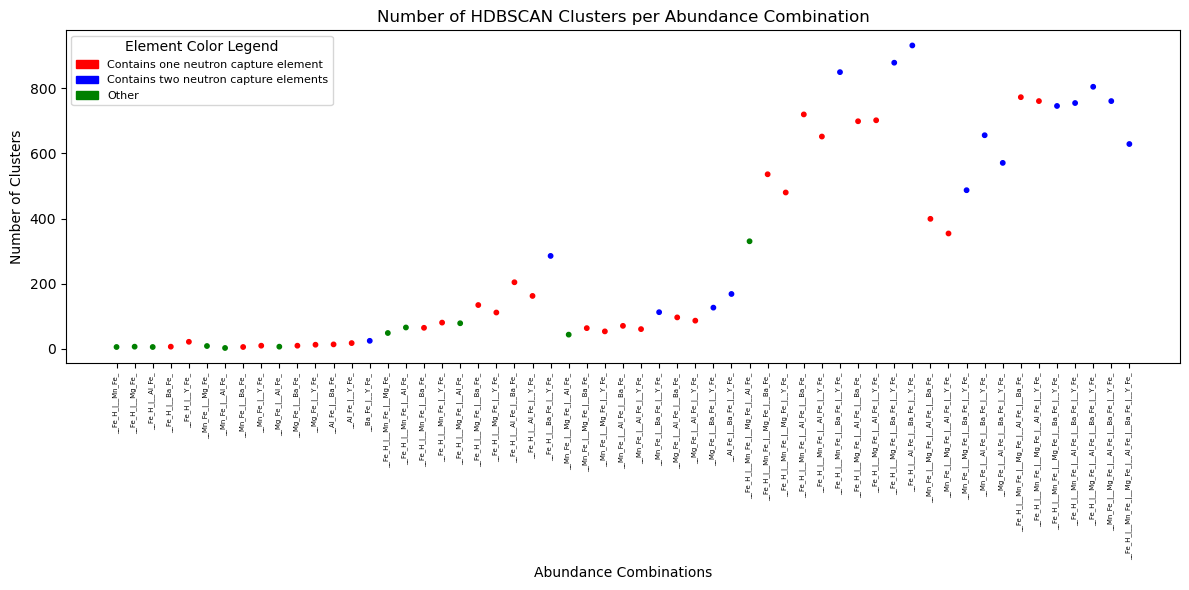

In [117]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

x_labels = list(cluster_counts.keys()) # assigns the names of combinations of abundances as the x-axis
y_values = list(cluster_counts.values()) # assigns the number of clusters as the y-axis

# makes the points corresponding to abundance combos with specific neutron capture elements show up in specific colors and all others show up in green
point_colors = []
for tag in x_labels:
    count = sum(elem in tag for elem in ['__Ba_Fe_', '__Y_Fe_'])
    
    if count == 1:
        point_colors.append('red')      # only one of the two
    elif count == 2:
        point_colors.append('blue')     # both
    else:
        point_colors.append('green')    # none of them
    
plt.figure(figsize=(12, 6))
plt.scatter(x_labels, y_values, color=point_colors, s=10)

# adds a legend for the colors
legend_handles = [
    mpatches.Patch(color='red', label='Contains one neutron capture element'),
    mpatches.Patch(color='blue', label='Contains two neutron capture elements'),
    mpatches.Patch(color='green', label='Other'),
]

plt.legend(handles=legend_handles, title='Element Color Legend', fontsize=8)

plt.xticks(rotation=90, fontsize=5) # improves readability of long x-axis labels by rotating 90 degrees and shrinking font size
plt.xlabel("Abundance Combinations")
plt.ylabel("Number of Clusters")
plt.title("Number of HDBSCAN Clusters per Abundance Combination")
plt.tight_layout()

plt.show()


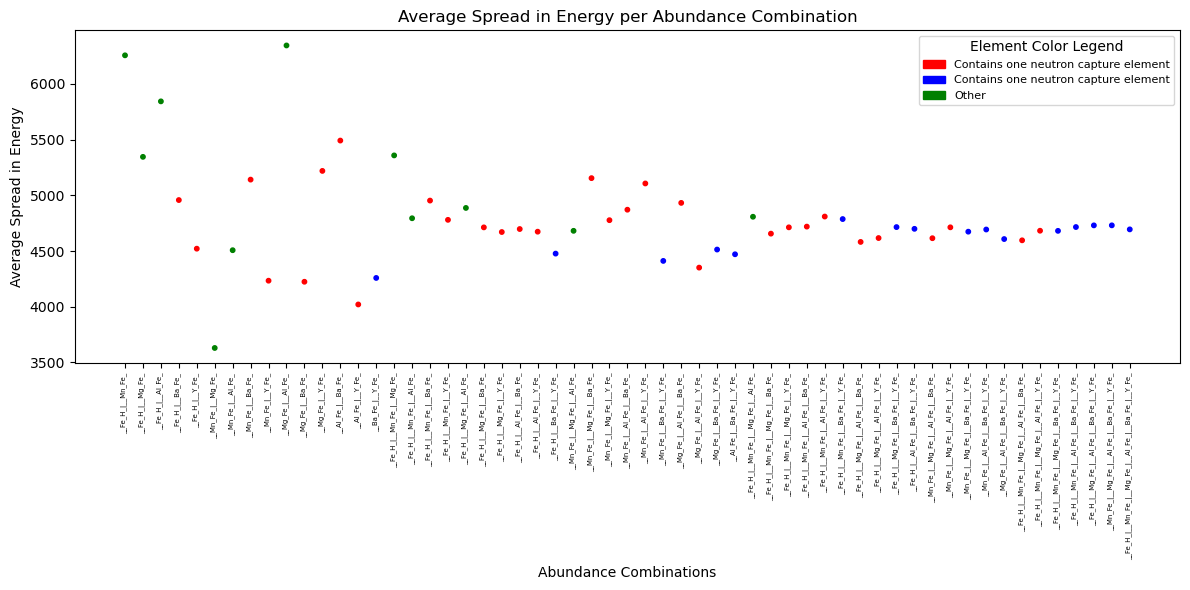

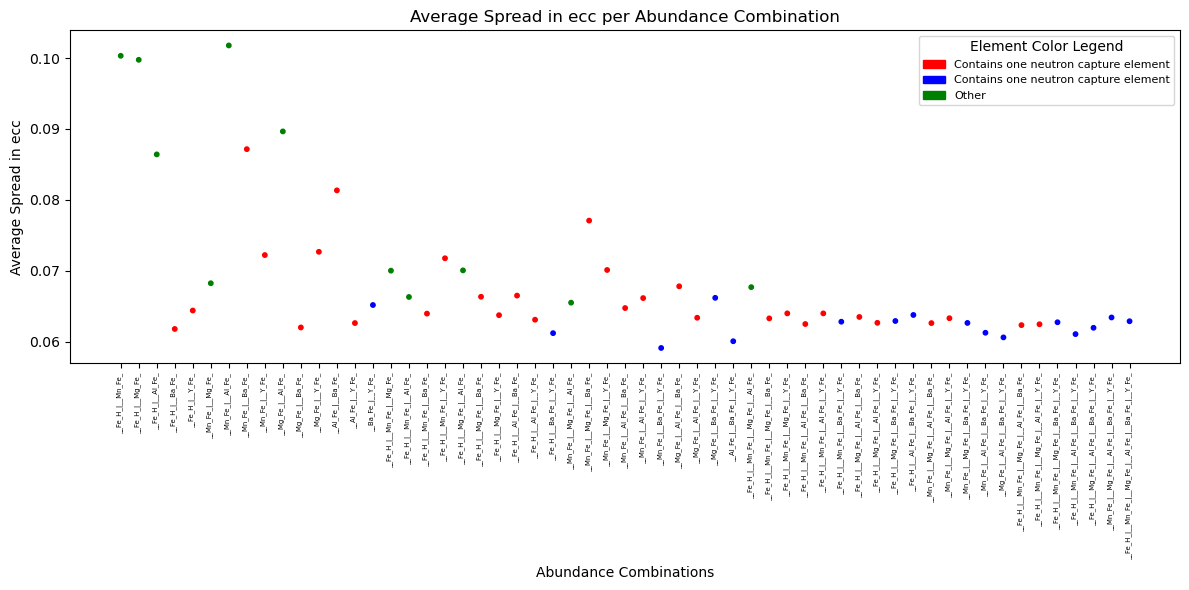

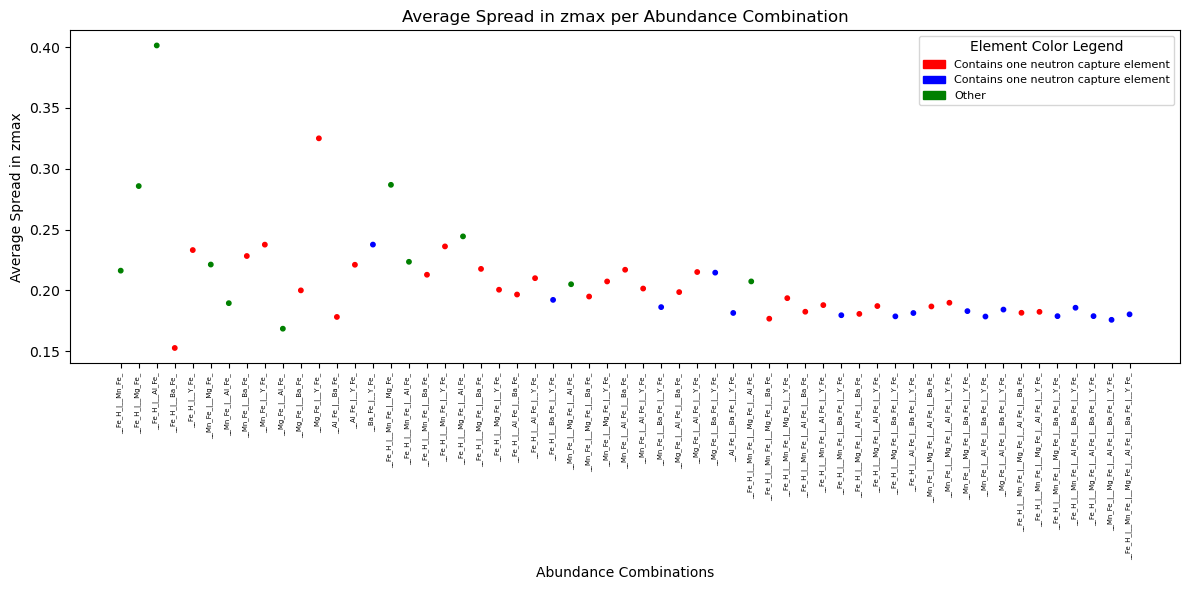

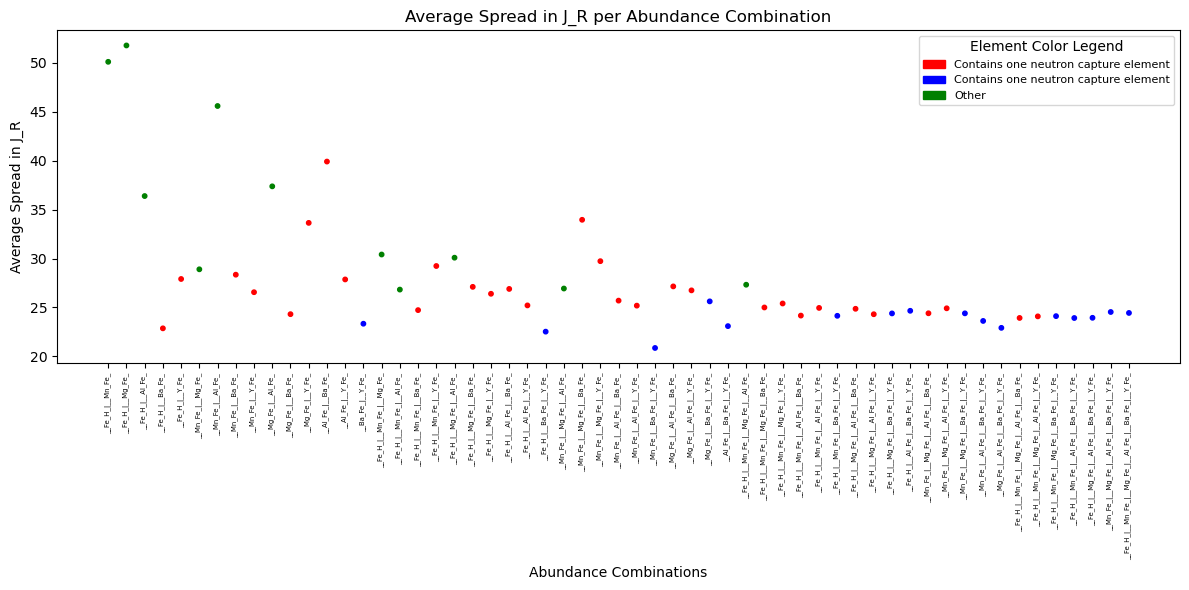

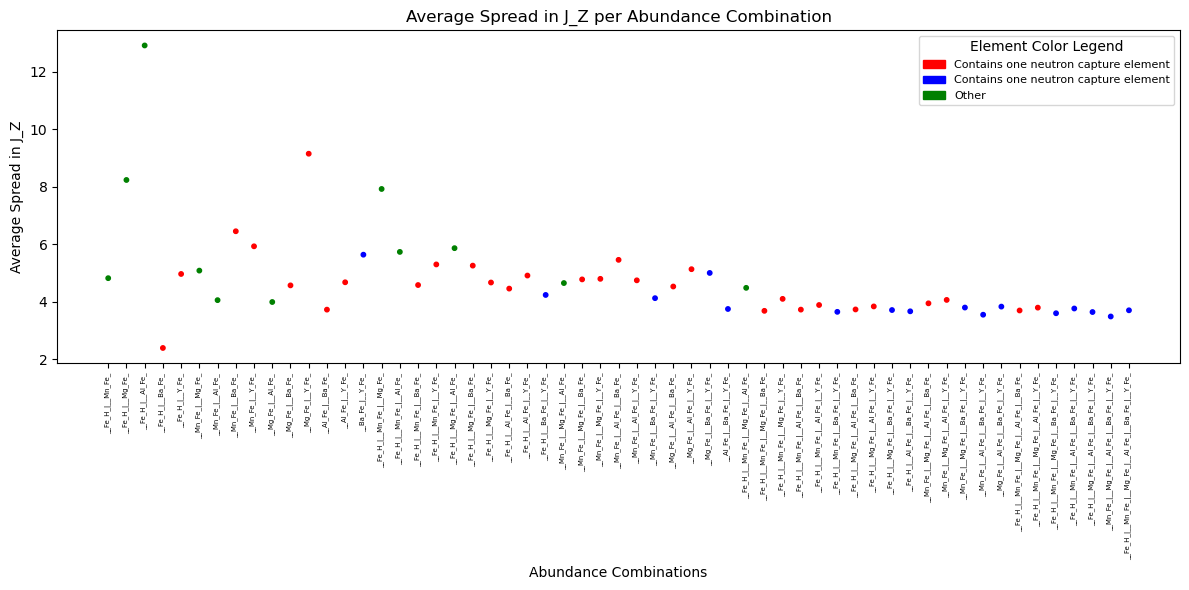

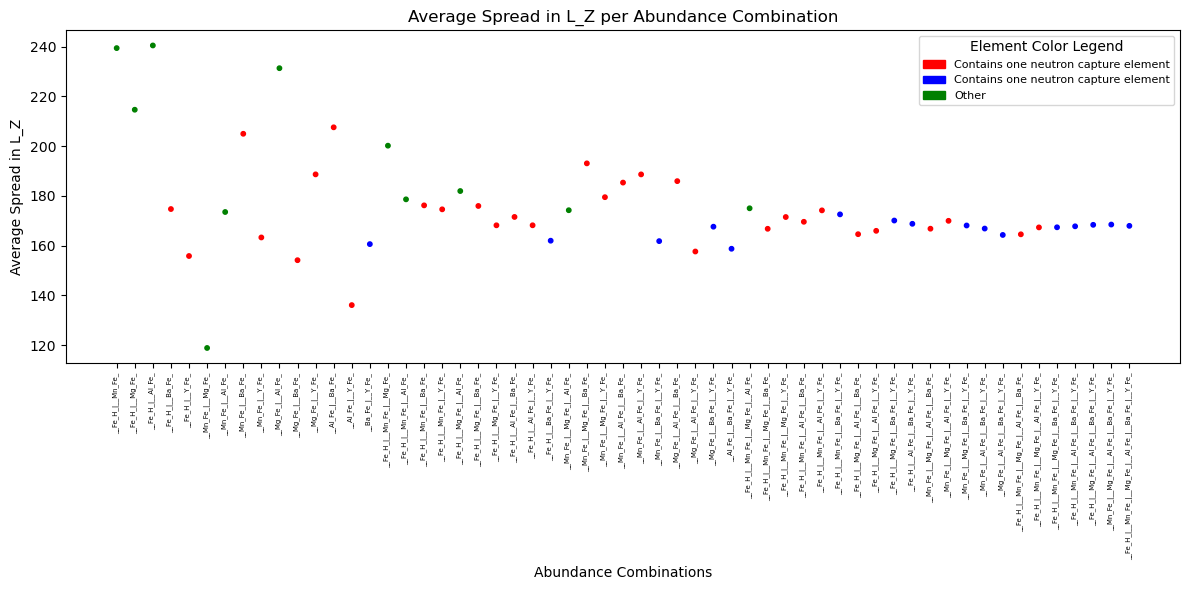

In [121]:
for col in spread_summary.columns:
    if col == 'combo_tag':  # avoid printing a plot with combo tag vs. combo tag
        continue  # skip this column
    plt.figure(figsize=(12, 6))
    x_labels = spread_summary['combo_tag'].tolist() # adds each combination of abundances to a list that becomes the x values
    y_values = spread_summary[col].values # extracts the values from the specified column and assigns them as the y value

    # makes the points corresponding to abundance combos with specific neutron capture elements show up in specific colors and all others show up in green
    point_colors = []
    for tag in x_labels:
        count = sum(elem in tag for elem in ['__Ba_Fe_', '__Y_Fe_'])
    
        if count == 1:
            point_colors.append('red')      # only one of the two
        elif count == 2:
            point_colors.append('blue')     # both
        else:
            point_colors.append('green')    # none of them
        
    plt.scatter(x_labels, y_values, color=point_colors, s=10)

    # adds a legend for the colors
    legend_handles = [
        mpatches.Patch(color='red', label='Contains one neutron capture element'),
        mpatches.Patch(color='blue', label='Contains one neutron capture element'),
        mpatches.Patch(color='green', label='Other'),
    ]
    plt.legend(handles=legend_handles, title='Element Color Legend', fontsize=8)
    plt.xticks(rotation=90, fontsize=5)
    plt.xlabel("Abundance Combinations")
    plt.ylabel(f"Average Spread in {col}") # flexible name that changes for each property
    plt.title(f"Average Spread in {col} per Abundance Combination")
    plt.tight_layout()
    plt.show()

In [294]:
print(repr(spread_summary.columns.tolist()))

['combo_tag', 'E', 'R_guide', 'ecc', 'z_max', 'J_R', 'J_z', 'L_z', 'L_x', 'L_y']


#### finding the fit for the results

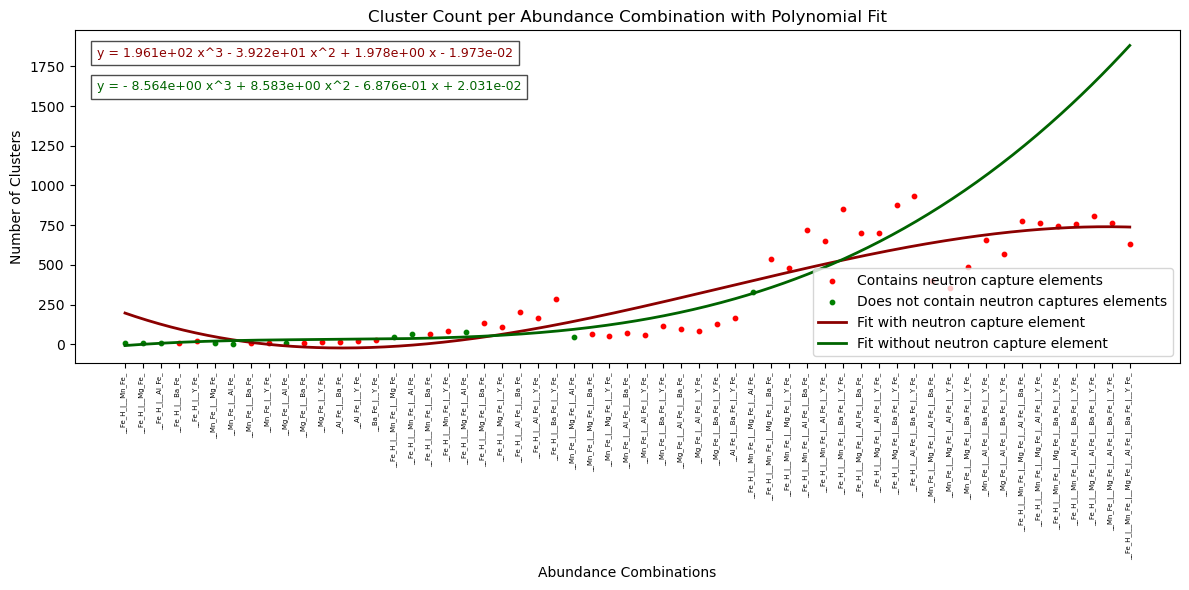

In [143]:
from scipy.optimize import curve_fit
from numpy.polynomial.polynomial import Polynomial

# Convert x_labels to numeric indices
x_labels = list(cluster_counts.keys()) # assigns the names of combinations of abundances as the x-axis
x_numeric = np.arange(len(x_labels))
y_values = np.array(list(cluster_counts.values()))

# Split data by color
red_x, red_y = [],[]
green_x, green_y = [],[]

for i, tag in enumerate(x_labels):
    if '__Ba_Fe_' in tag or '__Y_Fe_' in tag:
        red_x.append(x_numeric[i])
        red_y.append(y_values[i])
    else:
        green_x.append(x_numeric[i])
        green_y.append(y_values[i])

# Fit 3rd-degree polynomial
red_poly = Polynomial.fit(red_x, red_y, deg=3)
green_poly = Polynomial.fit(green_x, green_y, deg=3)

# Evaluate fits on smoother x-values
x_fit = np.linspace(0, len(x_labels) - 1, 500)
red_fit_y = red_poly(x_fit)
green_fit_y = green_poly(x_fit)

# Extract polynomial coefficients in standard form for equation display
red_coefs = red_poly.convert().coef
green_coefs = green_poly.convert().coef

def format_poly_eq(coefs):
    terms = []
    degree = len(coefs) - 1
    for i, c in enumerate(coefs):
        power = degree - i
        if abs(c) < 1e-12:
            continue
        sign = '+' if c > 0 else '-'
        c_abs = abs(c)
        if power == 0:
            term = f"{c_abs:.3e}"
        elif power == 1:
            term = f"{c_abs:.3e} x"
        else:
            term = f"{c_abs:.3e} x^{power}"
        terms.append(f" {sign} {term}")
    eq = ''.join(terms)
    # Fix leading plus sign:
    if eq.startswith(' +'):
        eq = eq[2:]
    return "y =" + eq

red_eq = format_poly_eq(red_coefs)
green_eq = format_poly_eq(green_coefs)

# Plot
plt.figure(figsize=(12, 6))
plt.scatter(red_x, red_y, color='red', s=10, label='Contains neutron capture elements')
plt.scatter(green_x, green_y, color='green', s=10, label='Does not contain neutron captures elements')
plt.plot(x_fit, red_fit_y, color='darkred', linewidth=2, label='Fit with neutron capture element')
plt.plot(x_fit, green_fit_y, color='darkgreen', linewidth=2, label='Fit without neutron capture element')
plt.xticks(ticks=x_numeric, labels=x_labels, rotation=90, fontsize=5)
plt.xlabel("Abundance Combinations")
plt.ylabel("Number of Clusters")
plt.title("Cluster Count per Abundance Combination with Polynomial Fit")
plt.legend(loc='lower right')

# Add equation texts to the plot (top-left and top-right)
plt.text(0.02, 0.95, red_eq, transform=plt.gca().transAxes, fontsize=9,
         color='darkred', verticalalignment='top', bbox=dict(facecolor='white', alpha=0.7))
plt.text(0.02, 0.85, green_eq, transform=plt.gca().transAxes, fontsize=9,
         color='darkgreen', verticalalignment='top', bbox=dict(facecolor='white', alpha=0.7))

plt.tight_layout()
plt.show()

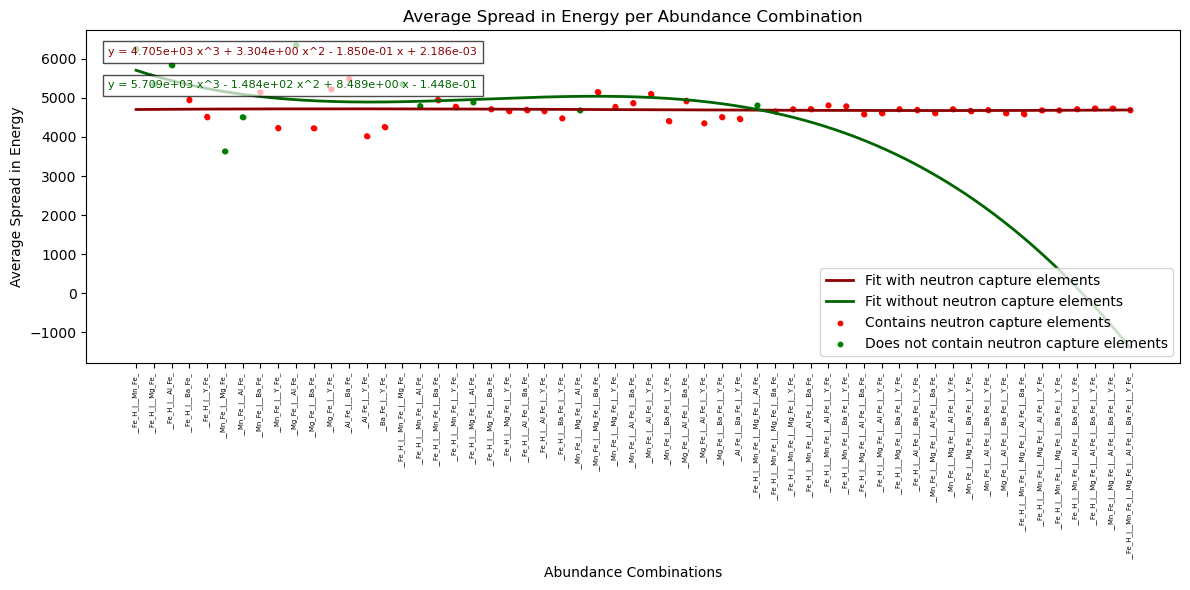

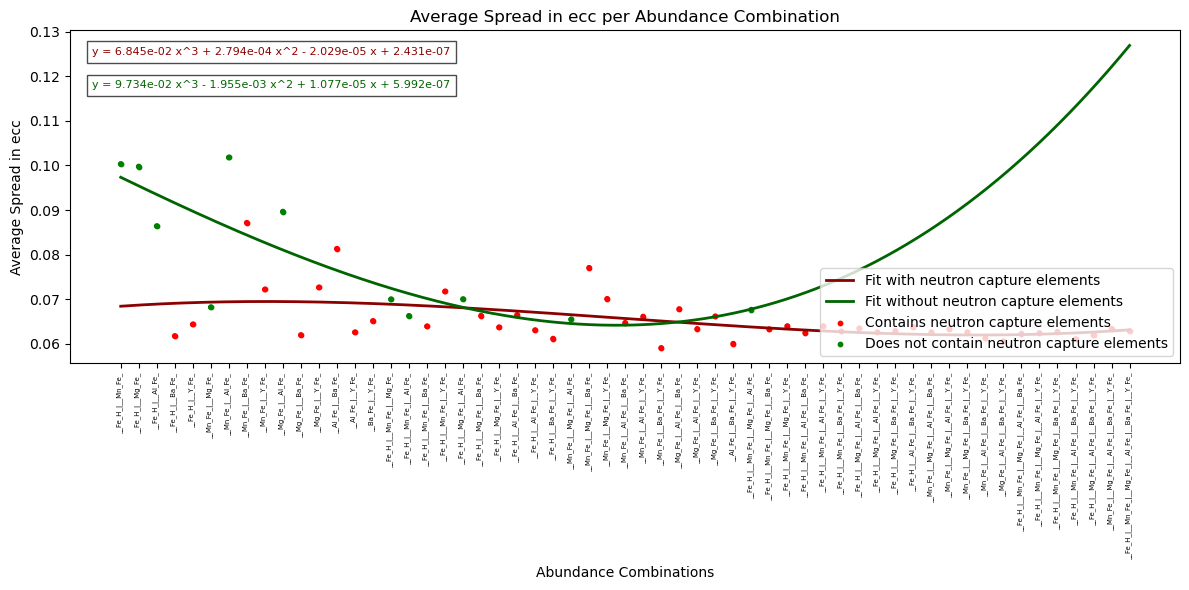

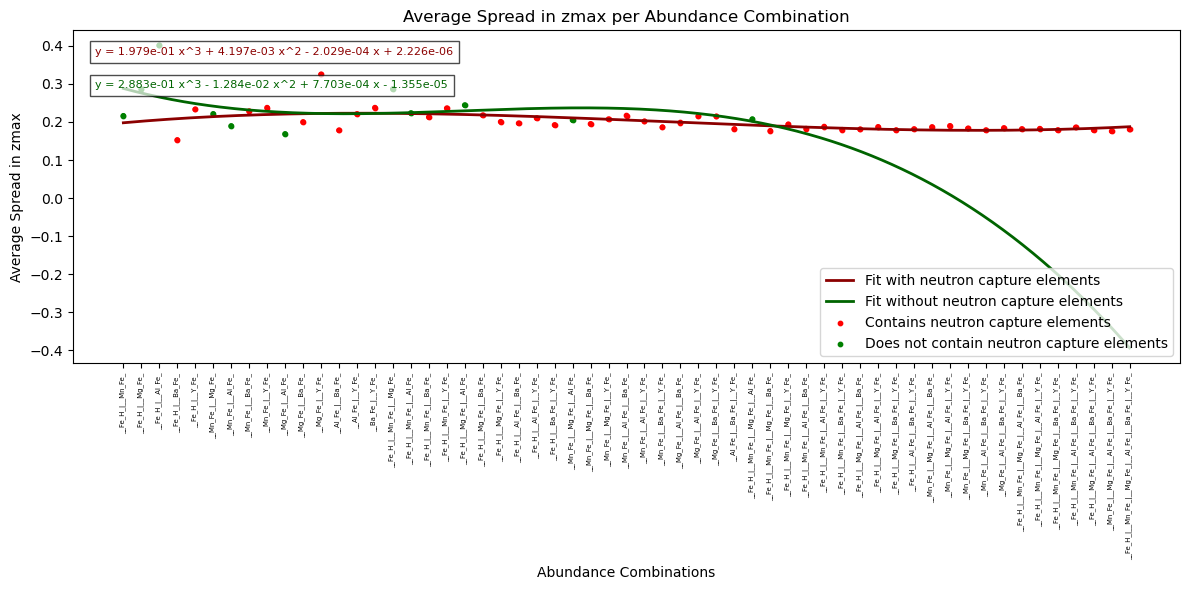

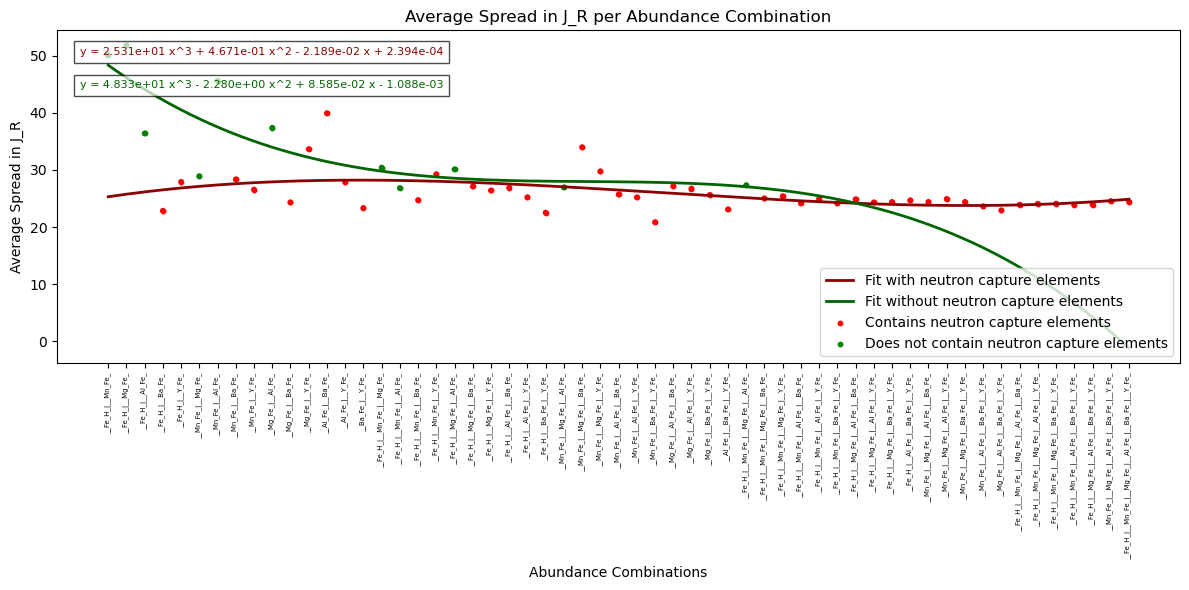

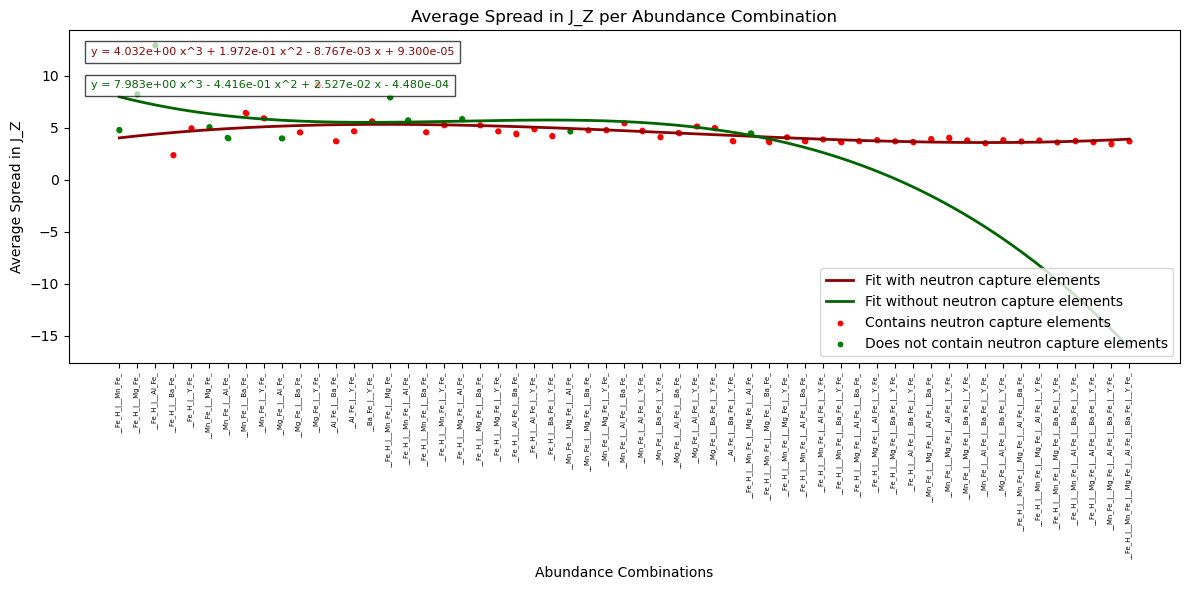

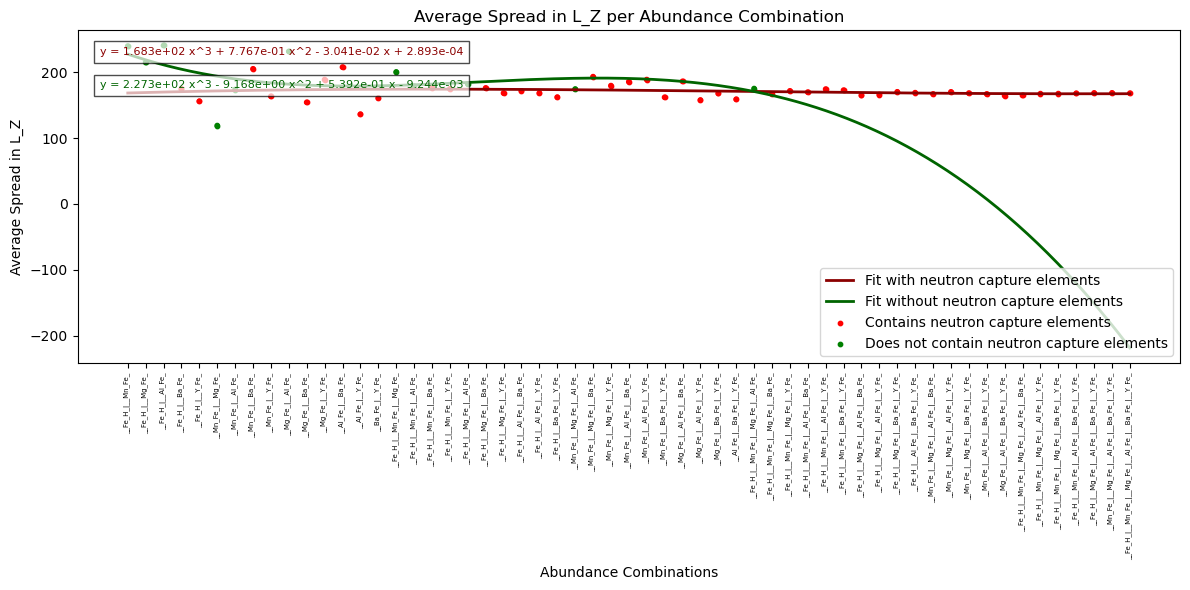

In [187]:
for col in spread_summary.columns:
    if col == 'combo_tag':
        continue  # skip combo_tag column
    plt.figure(figsize=(12, 6))
    
    x_labels = spread_summary['combo_tag'].tolist()
    y_values = spread_summary[col].values

    x_numeric = np.arange(len(x_labels))

    # Split data by color
    red_x, red_y = [], []
    green_x, green_y = [], []

    for i, tag in enumerate(x_labels):
        if '__Ba_Fe_' in str(tag) or '__Y_Fe_' in str(tag):
            red_x.append(x_numeric[i])
            red_y.append(y_values[i])
        else:
            green_x.append(x_numeric[i])
            green_y.append(y_values[i])

    # Fit 3rd-degree polynomial where data exists
    red_poly = None
    green_poly = None
    if len(red_x) >= 4:
        red_poly = Polynomial.fit(red_x, red_y, deg=3)
    if len(green_x) >= 4:
        green_poly = Polynomial.fit(green_x, green_y, deg=3)

    x_fit = np.linspace(0, len(x_labels) - 1, 500)

    # Evaluate polynomial fits
    red_fit_y = red_poly(x_fit) if red_poly else None
    green_fit_y = green_poly(x_fit) if green_poly else None

    # Prepare polynomial equations for display
    def format_poly_eq(coefs):
        terms = []
        degree = len(coefs) - 1
        for i, c in enumerate(coefs):
            power = degree - i
            if abs(c) < 1e-12:
                continue
            sign = '+' if c > 0 else '-'
            c_abs = abs(c)
            if power == 0:
                term = f"{c_abs:.3e}"
            elif power == 1:
                term = f"{c_abs:.3e} x"
            else:
                term = f"{c_abs:.3e} x^{power}"
            terms.append(f" {sign} {term}")
        eq = ''.join(terms)
        if eq.startswith(' +'):
            eq = eq[2:]
        return "y =" + eq

    red_eq = format_poly_eq(red_poly.convert().coef) if red_poly else "Not enough red points to fit"
    green_eq = format_poly_eq(green_poly.convert().coef) if green_poly else "Not enough green points to fit"

    # Scatter plot
    point_colors = ['red' if '__Ba_Fe_' in str(tag) or '__Y_Fe_' in str(tag) else 'green' for tag in x_labels]
    plt.scatter(x_numeric, y_values, color=point_colors, s=10)

    # Plot polynomial fits
    if red_fit_y is not None:
        plt.plot(x_fit, red_fit_y, color='darkred', linewidth=2, label='Fit with neutron capture elements')
    if green_fit_y is not None:
        plt.plot(x_fit, green_fit_y, color='darkgreen', linewidth=2, label='Fit without neutron capture elements')

    plt.scatter(red_x, red_y, color='red', s=10, label='Contains neutron capture elements')
    plt.scatter(green_x, green_y, color='green', s=10, label='Does not contain neutron capture elements')
   
    # Set x-axis labels
    plt.xticks(ticks=x_numeric, labels=x_labels, rotation=90, fontsize=5)

    plt.xlabel("Abundance Combinations")
    plt.ylabel(f"Average Spread in {col}")
    plt.title(f"Average Spread in {col} per Abundance Combination")
    plt.legend(loc='lower right')

    # Add equation text in upper left, separated vertically
    plt.text(0.02, 0.95, red_eq, transform=plt.gca().transAxes, fontsize=8,
             color='darkred', verticalalignment='top', bbox=dict(facecolor='white', alpha=0.7))
    plt.text(0.02, 0.85, green_eq, transform=plt.gca().transAxes, fontsize=8,
             color='darkgreen', verticalalignment='top', bbox=dict(facecolor='white', alpha=0.7))

    plt.tight_layout()
    plt.show()

Average percent difference between fits: 156.38%


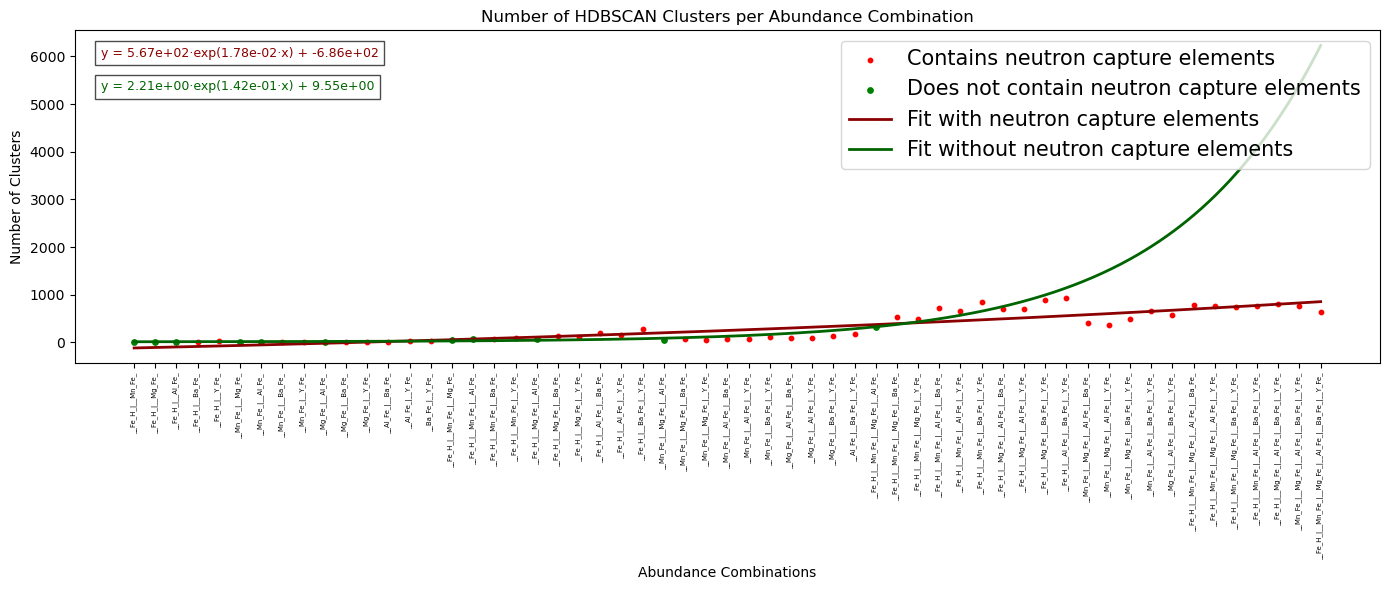

In [212]:
# Define exponential function
def exp_func(x, a, b, c):
    return a * np.exp(b * x) + c

# Prepare data
x_labels = list(cluster_counts.keys())
y_values = list(cluster_counts.values())
x_numeric = np.arange(len(x_labels))  # numeric x for fitting
y_values = np.array(y_values)

# Split by neutron capture elements
red_x, red_y = [], []
green_x, green_y = [], []

for i, tag in enumerate(x_labels):
    if '__Ba_Fe_' in tag or '__Y_Fe_' in tag:
        red_x.append(x_numeric[i])
        red_y.append(y_values[i])
    else:
        green_x.append(x_numeric[i])
        green_y.append(y_values[i])

# Fit exponential model
x_fit = np.linspace(0, len(x_labels)-1, 500)

if len(red_x) >= 3:
    popt_red, _ = curve_fit(exp_func, red_x, red_y, p0=(1, 1e-6, 1), maxfev=10000)
    red_fit_y = exp_func(x_fit, *popt_red)
    red_eq = f"y = {popt_red[0]:.2e}·exp({popt_red[1]:.2e}·x) + {popt_red[2]:.2e}"

if len(green_x) >= 3:
    popt_green, _ = curve_fit(exp_func, green_x, green_y, p0=(1, 1e-6, 1), maxfev=10000)
    green_fit_y = exp_func(x_fit, *popt_green)
    green_eq = f"y = {popt_green[0]:.2e}·exp({popt_green[1]:.2e}·x) + {popt_green[2]:.2e}"

# ---- Percent difference calculation ----
if popt_red is not None and popt_green is not None:
    # Calculate percent difference across the same x_fit range
    y_red = exp_func(x_fit, *popt_red)
    y_green = exp_func(x_fit, *popt_green)

percent_diff = (y_green - y_red) / y_red * 100  # relative to red
avg_percent_diff = np.mean(np.abs(percent_diff))
print(f"Average percent difference between fits: {avg_percent_diff:.2f}%")

# Create the scatter plot
plt.figure(figsize=(14, 6))
point_colors = ['red' if '__Ba_Fe_' in tag or '__Y_Fe_' in tag else 'green' for tag in x_labels]
plt.scatter(red_x, red_y, color='red', s=10, label='Contains neutron capture elements')
plt.scatter(green_x, green_y, color='green', s=15, label='Does not contain neutron capture elements')

# Plot fits
plt.plot(x_fit, red_fit_y, color='darkred', linewidth=2, label='Fit with neutron capture elements')
plt.text(0.02, 0.95, red_eq, transform=plt.gca().transAxes, fontsize=9,
             color='darkred', verticalalignment='top', bbox=dict(facecolor='white', alpha=0.7))

plt.plot(x_fit, green_fit_y, color='darkgreen', linewidth=2, label='Fit without neutron capture elements')
plt.text(0.02, 0.85, green_eq, transform=plt.gca().transAxes, fontsize=9,
             color='darkgreen', verticalalignment='top', bbox=dict(facecolor='white', alpha=0.7))

# Format x-axis with original labels
plt.xticks(ticks=x_numeric, labels=x_labels, rotation=90, fontsize=5)
plt.xlabel("Abundance Combinations")
plt.ylabel("Number of Clusters")
plt.title("Number of HDBSCAN Clusters per Abundance Combination")
plt.legend(loc='upper right', fontsize = 15)
plt.tight_layout()
plt.show()

Average percent difference between fits: 2.18%


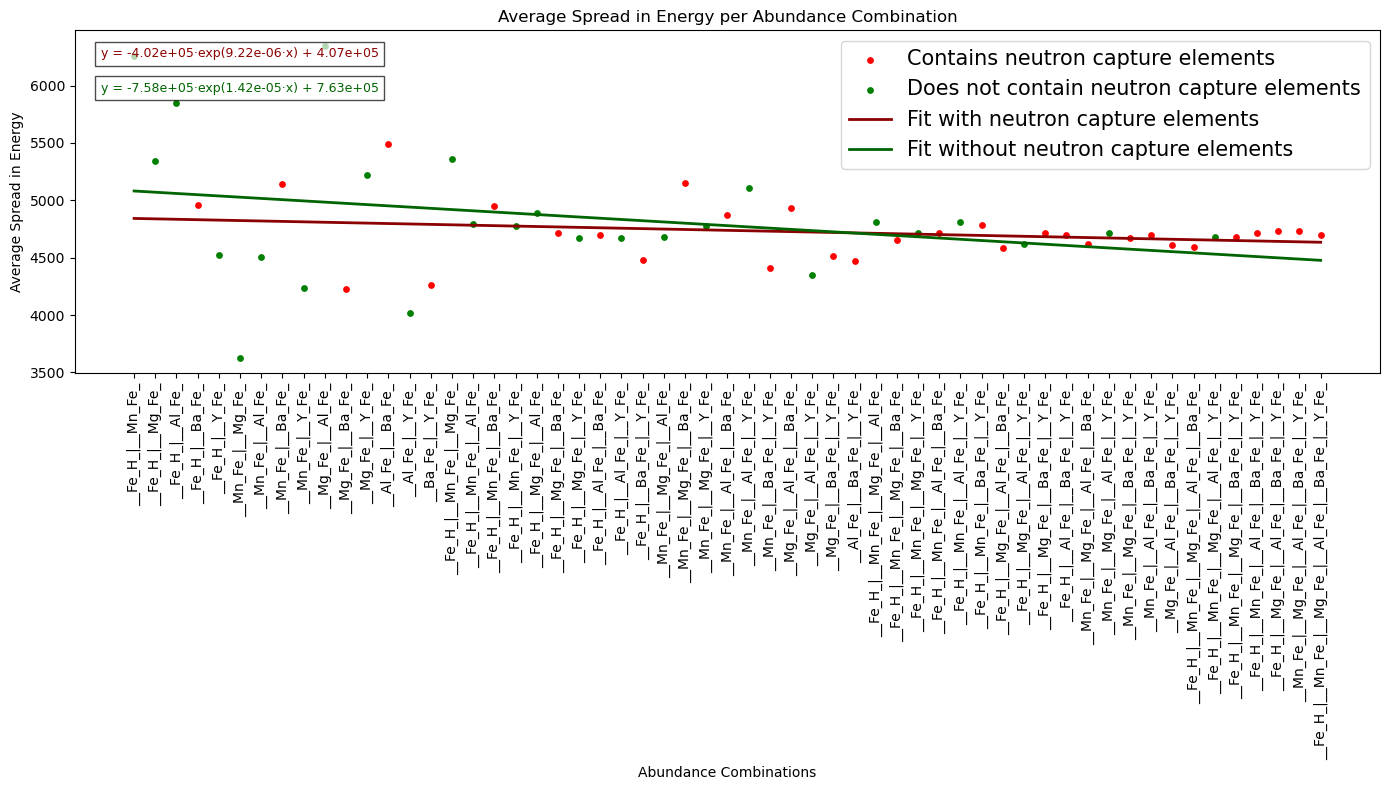

Average percent difference between fits: 4.26%


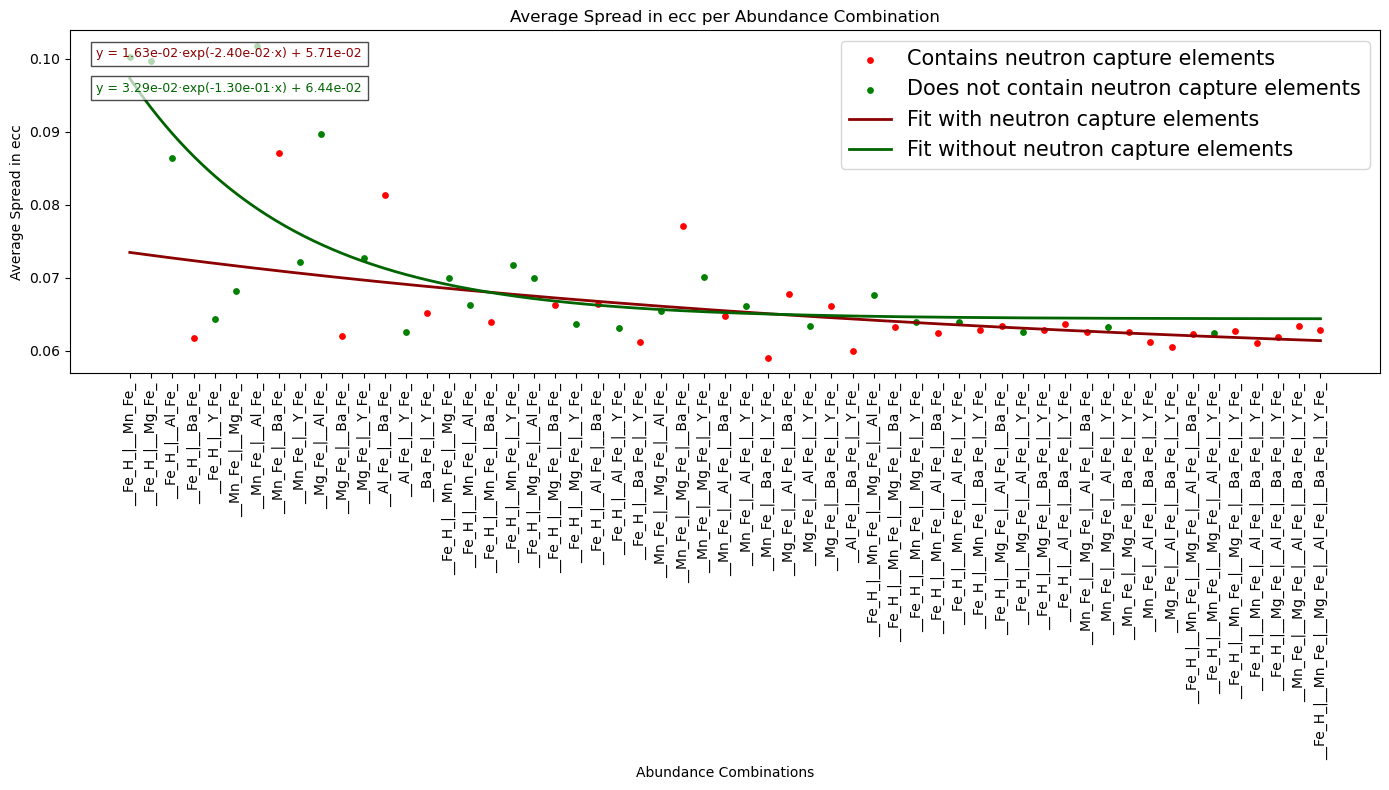

Average percent difference between fits: 10.19%


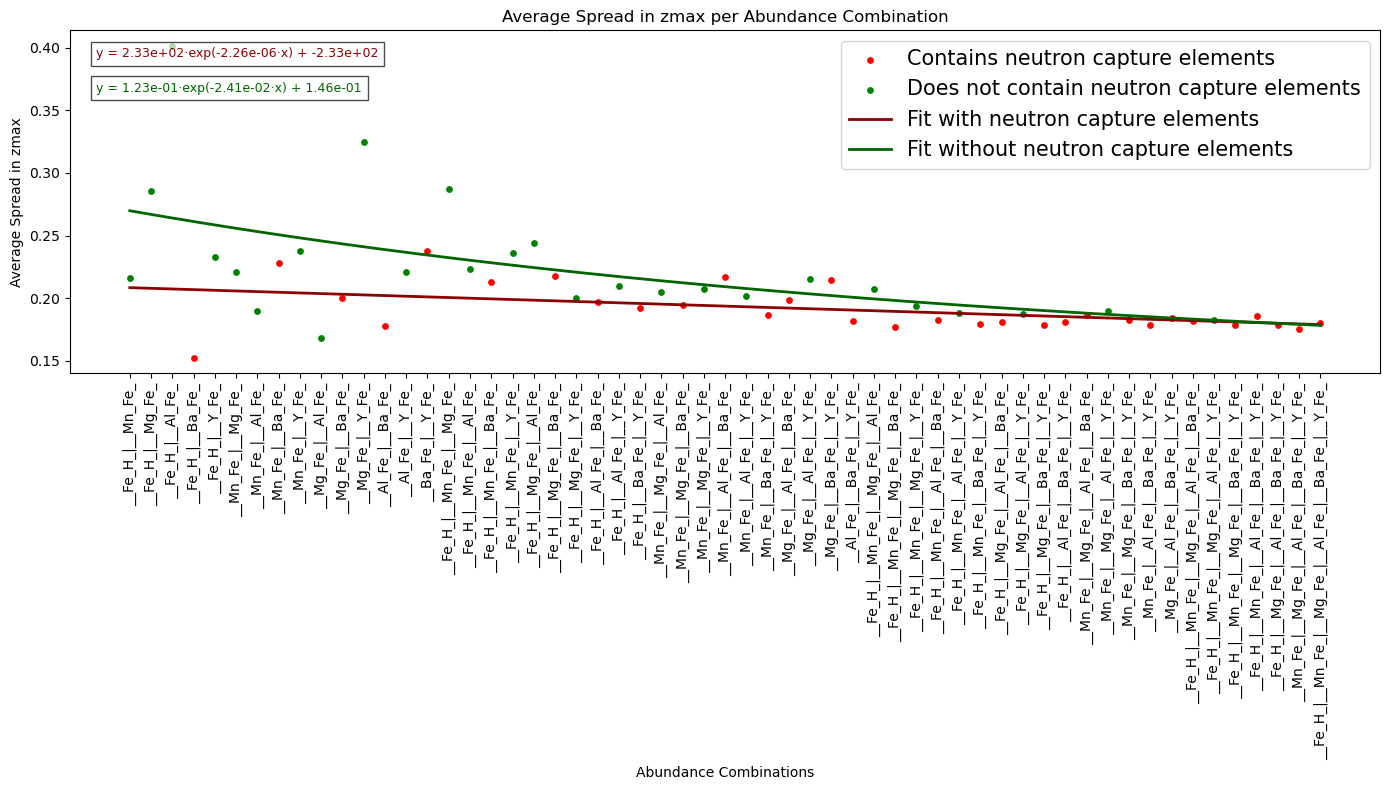

Average percent difference between fits: 15.66%


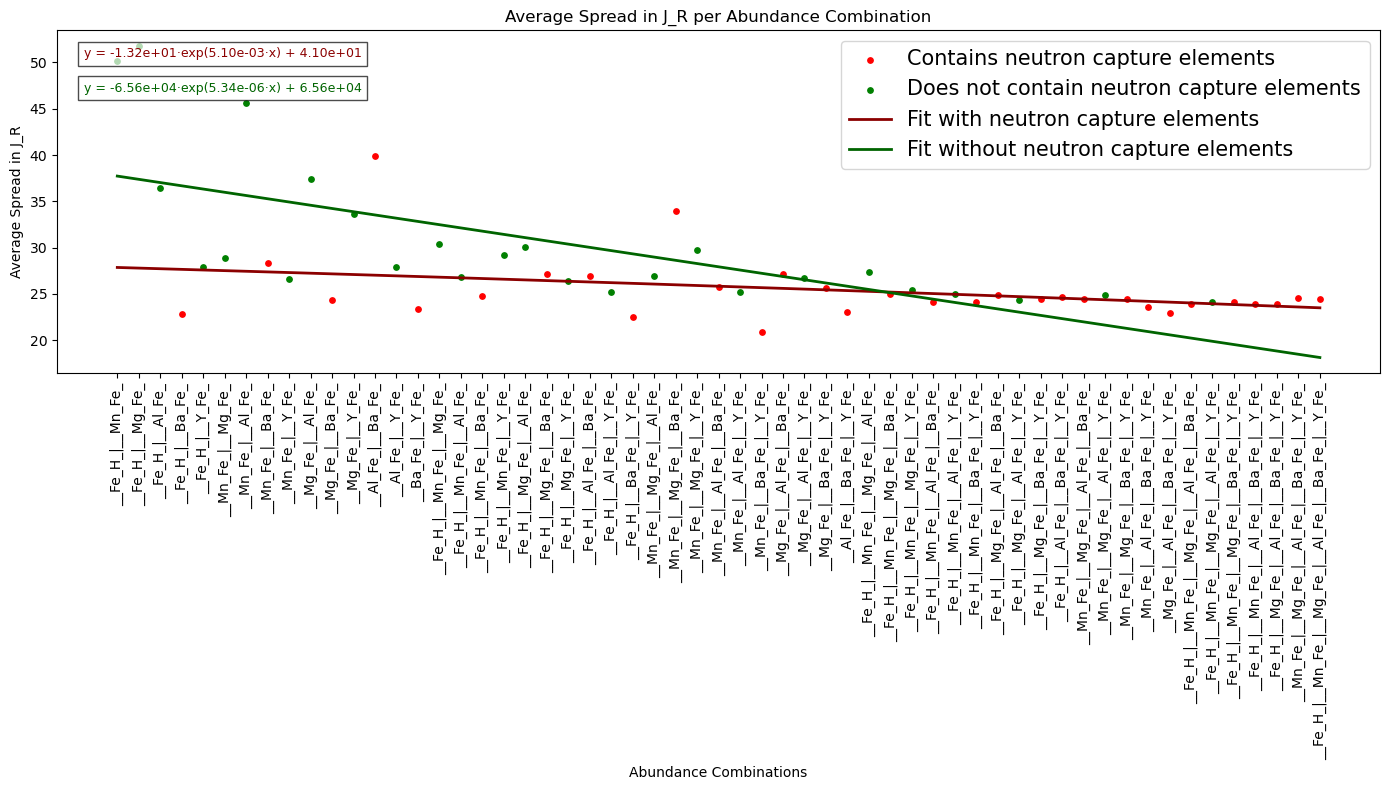

Average percent difference between fits: 15.11%


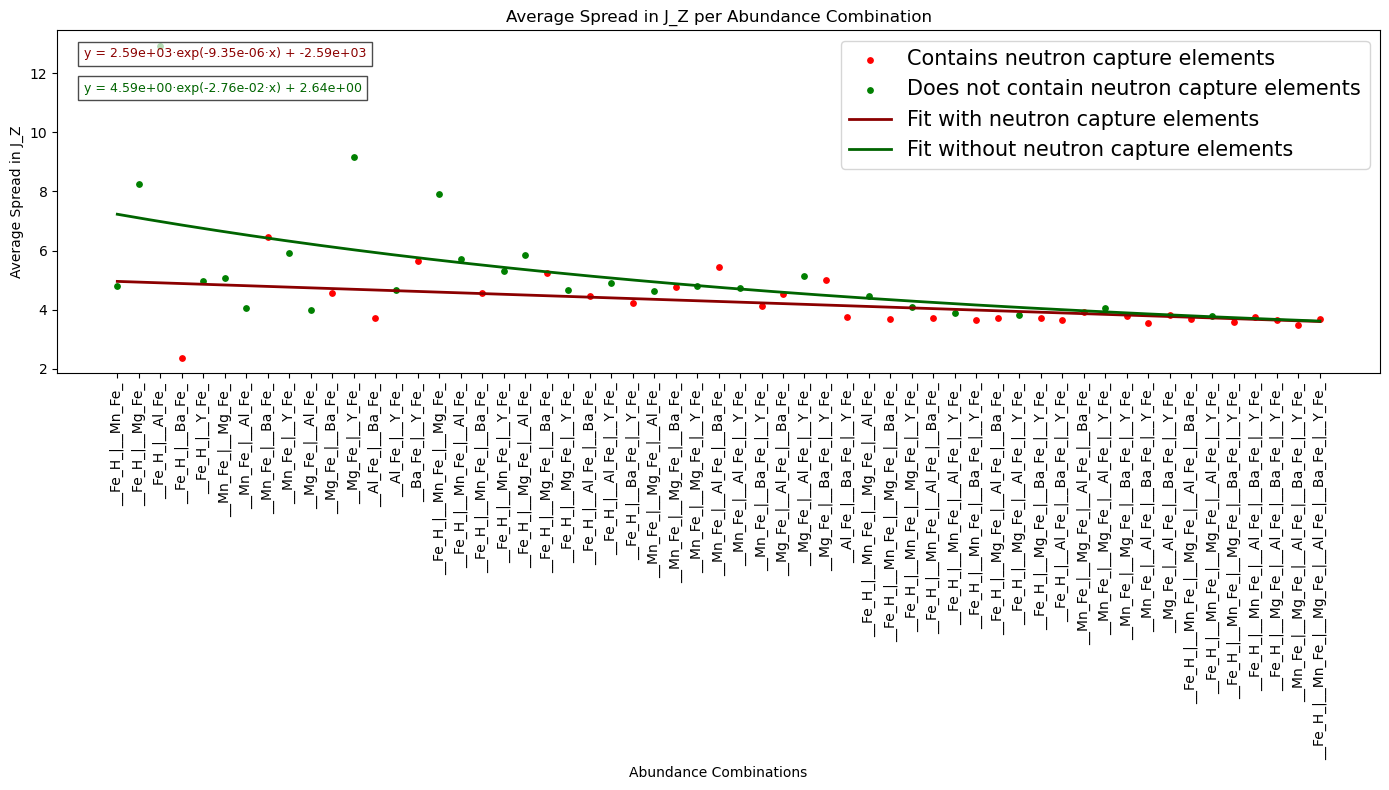

Average percent difference between fits: 2.88%


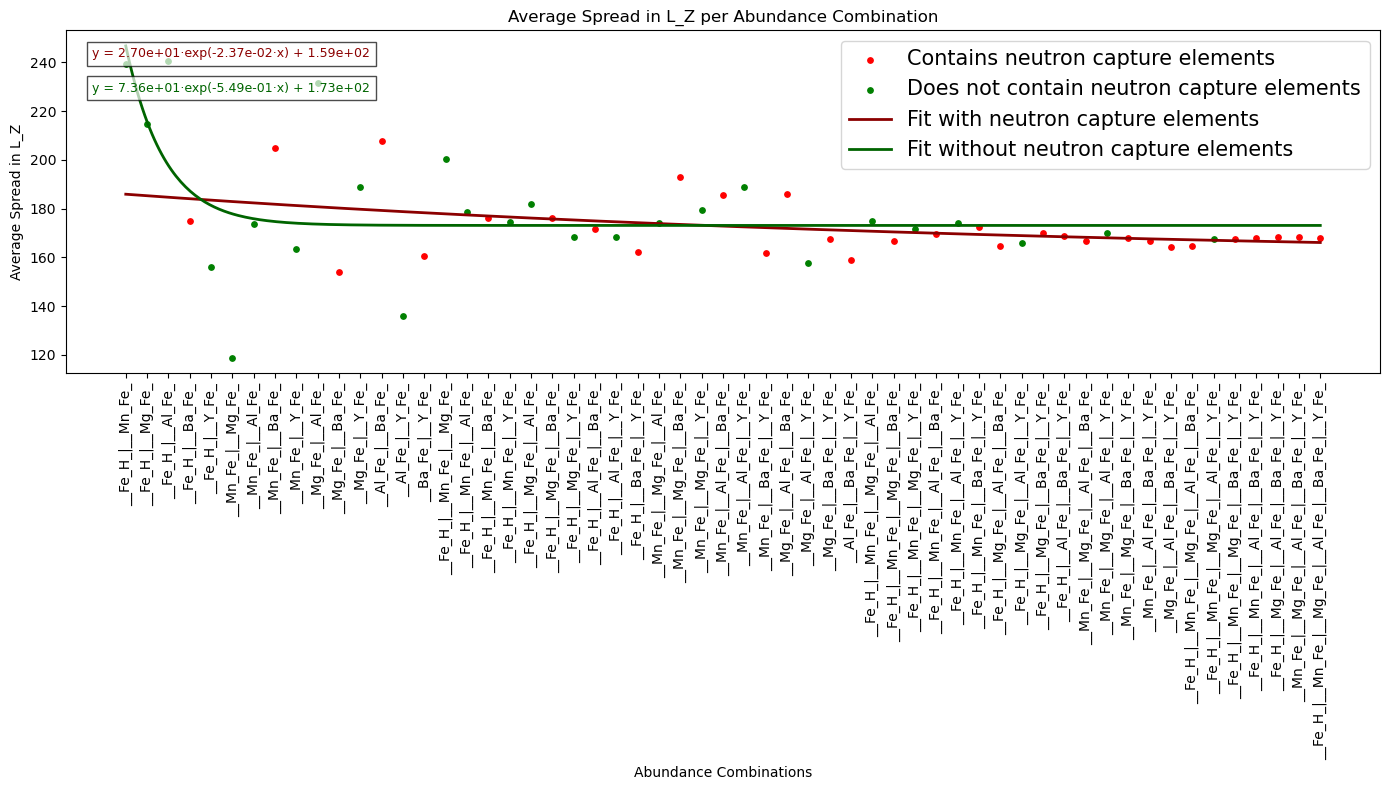

Average percent difference between fits: 100.00%


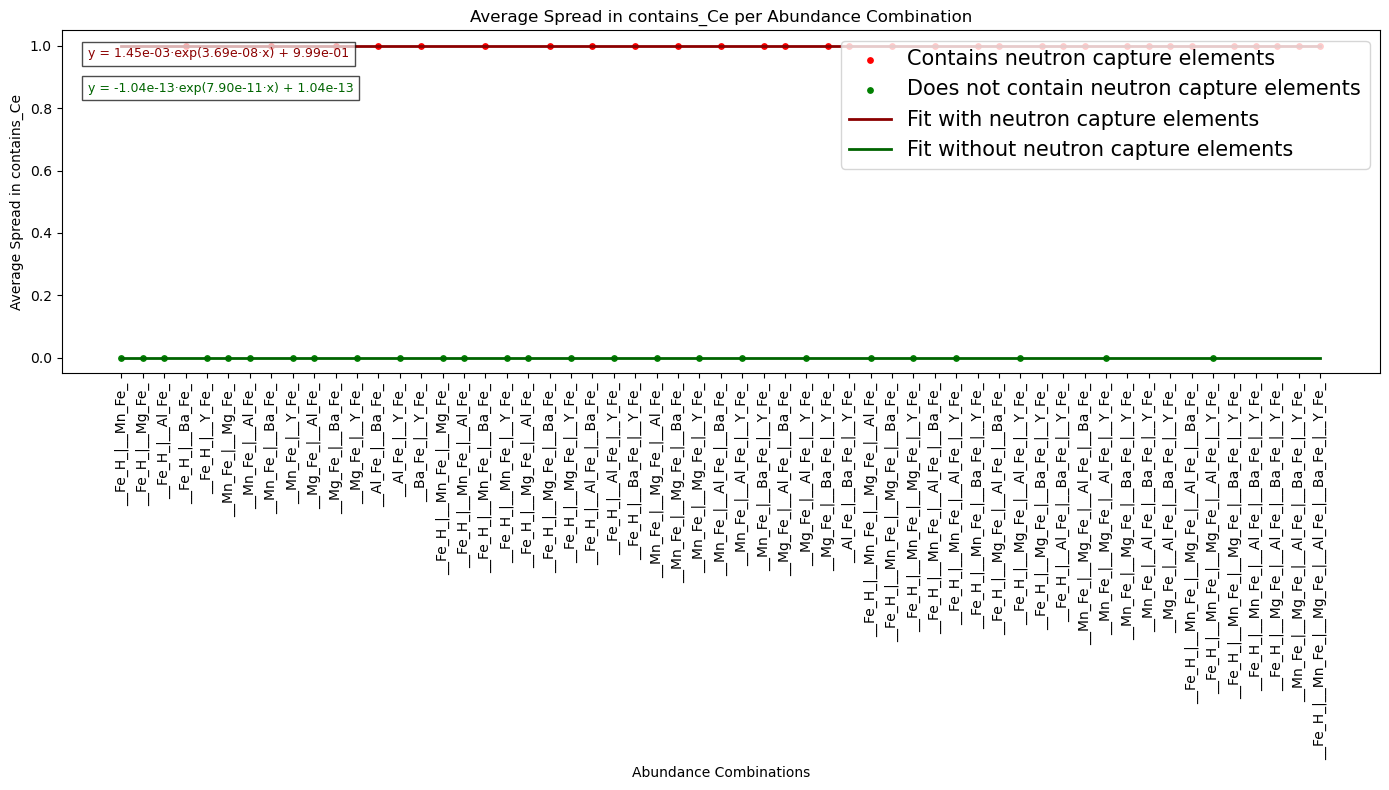

ValueError: could not convert string to float: '__Fe_H_'

In [222]:
for col in spread_summary.columns:
    if col == 'combo_tag':
        continue  # skip combo_tag column
    # Prepare data
    x_labels = spread_summary['combo_tag'].tolist() # adds ea
    y_values = spread_summary[col].values
    x_numeric = np.arange(len(x_labels))  # numeric x for fitting
    y_values = np.array(y_values)
    
    # Split by CE_FE
    red_x, red_y = [], []
    green_x, green_y = [], []
    
    for i, tag in enumerate(x_labels):
        if '__Ba_Fe_' in tag or '__Ba_Fe_' in tag:
            red_x.append(x_numeric[i])
            red_y.append(y_values[i])
        else:
            green_x.append(x_numeric[i])
            green_y.append(y_values[i])
    
    # Fit exponential model
    x_fit = np.linspace(0, len(x_labels)-1, 500)
    
    if len(red_x) >= 3:
        popt_red, _ = curve_fit(exp_func, red_x, red_y, p0=(1, 1e-6, 1), maxfev=10000)
        red_fit_y = exp_func(x_fit, *popt_red)
        red_eq = f"y = {popt_red[0]:.2e}·exp({popt_red[1]:.2e}·x) + {popt_red[2]:.2e}"
    
    if len(green_x) >= 3:
        popt_green, _ = curve_fit(exp_func, green_x, green_y, p0=(1, 1e-6, 1), maxfev=10000)
        green_fit_y = exp_func(x_fit, *popt_green)
        green_eq = f"y = {popt_green[0]:.2e}·exp({popt_green[1]:.2e}·x) + {popt_green[2]:.2e}"

        # ---- Percent difference calculation ----
    if popt_red is not None and popt_green is not None:
        # Calculate percent difference across the same x_fit range
        y_red = exp_func(x_fit, *popt_red)
        y_green = exp_func(x_fit, *popt_green)

    percent_diff = (y_green - y_red) / y_red * 100  # relative to red
    avg_percent_diff = np.mean(np.abs(percent_diff))
    print(f"Average percent difference between fits: {avg_percent_diff:.2f}%")
    
    # Create the scatter plot
    plt.figure(figsize=(14, 8))
    point_colors = ['red' if '__Ba_Fe_' in tag or '__Y_Fe_' in tag else 'green' for tag in x_labels]
    plt.scatter(red_x, red_y, color='red', s=15, label='Contains neutron capture elements')
    plt.scatter(green_x, green_y, color='green', s=15, label='Does not contain neutron capture elements')
    
    # Plot fits
    plt.plot(x_fit, red_fit_y, color='darkred', linewidth=2, label='Fit with neutron capture elements')
    plt.text(0.02, 0.95, red_eq, transform=plt.gca().transAxes, fontsize=9,
                 color='darkred', verticalalignment='top', bbox=dict(facecolor='white', alpha=0.7))
    
    plt.plot(x_fit, green_fit_y, color='darkgreen', linewidth=2, label='Fit without neutron capture elements')
    plt.text(0.02, 0.85, green_eq, transform=plt.gca().transAxes, fontsize=9,
                 color='darkgreen', verticalalignment='top', bbox=dict(facecolor='white', alpha=0.7))
    
    # Format x-axis with original labels
    plt.xticks(ticks=x_numeric, labels=x_labels, rotation=90, fontsize=10)
    plt.xlabel("Abundance Combinations")
    plt.ylabel(f"Average Spread in {col}")
    plt.title(f"Average Spread in {col} per Abundance Combination")
    plt.legend(loc='upper right', fontsize = 15)
    plt.tight_layout()
    plt.show()
        

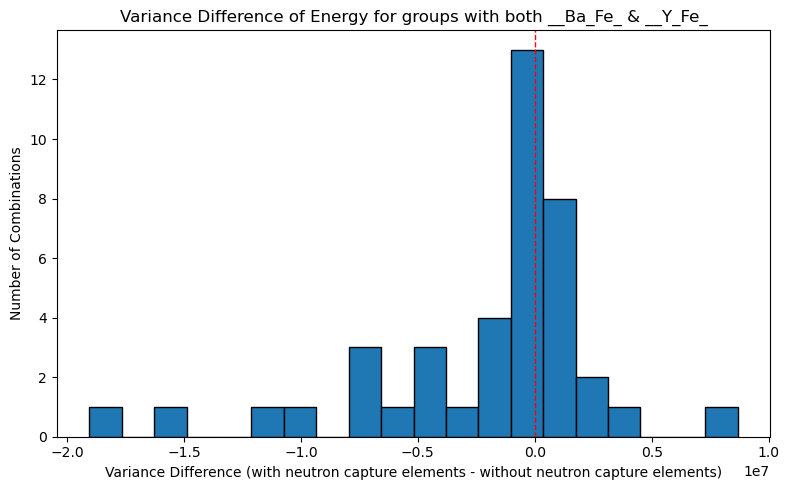

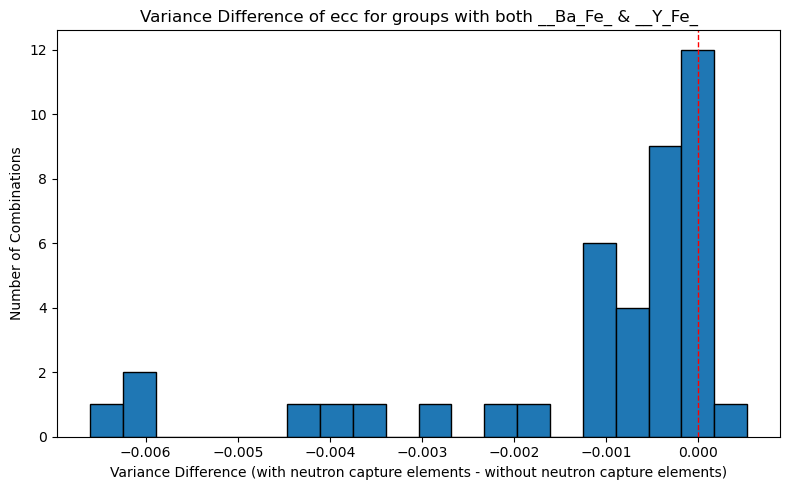

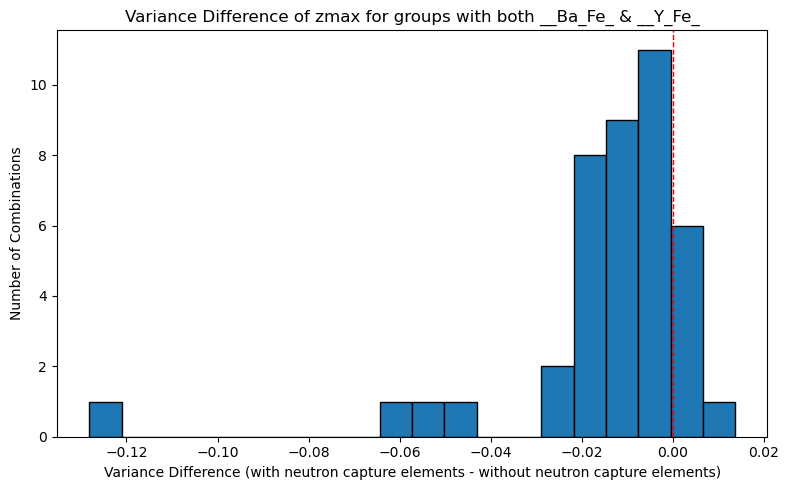

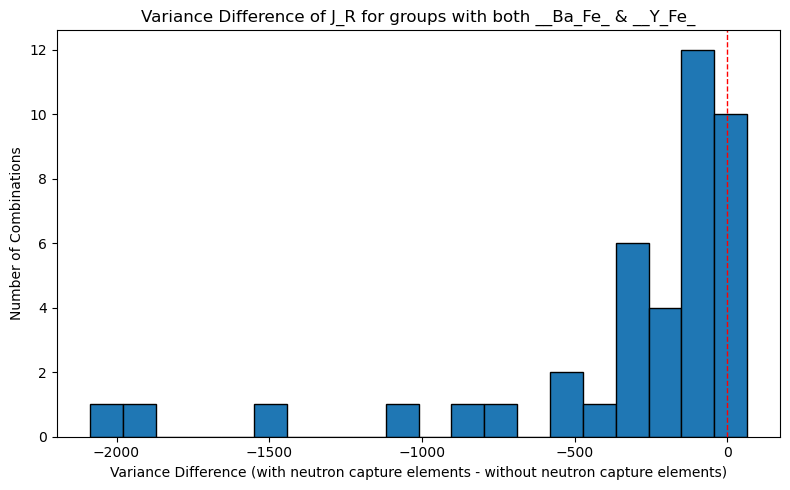

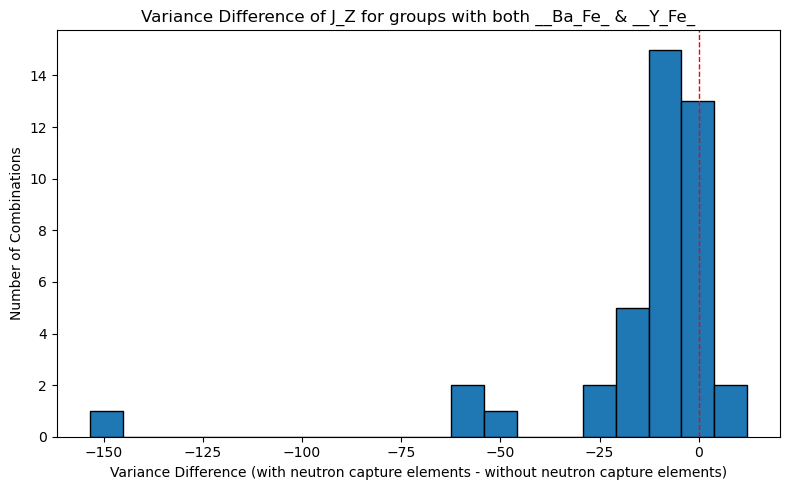

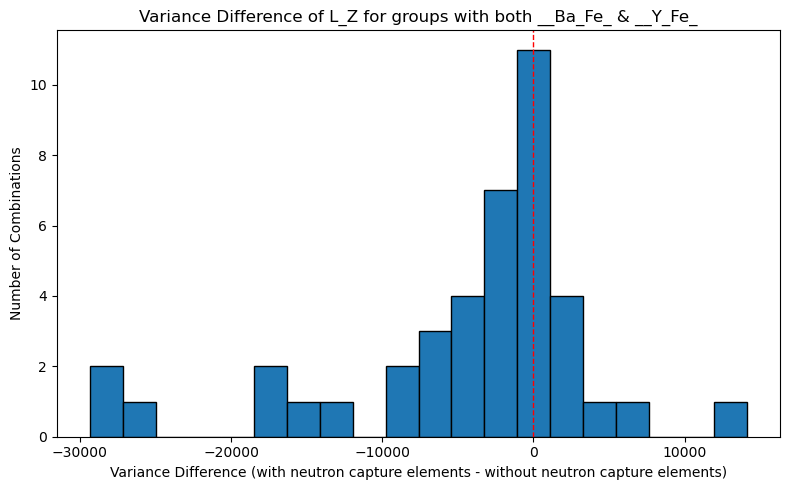

In [210]:
import re

# --- SETTINGS ---
elem1 = "__Ba_Fe_"
elem2 = "__Y_Fe_"
mode = "both"   # options: "both", "one"

# --- DETECTION LOGIC ---
if mode == "both":
    spread_summary["contains_target"] = (
        spread_summary["combo_tag"].str.contains(elem1, case=False, na=False) &
        spread_summary["combo_tag"].str.contains(elem2, case=False, na=False)
    )
elif mode == "one":
    spread_summary["contains_target"] = (
        spread_summary["combo_tag"].str.contains(elem1, case=False, na=False) ^
        spread_summary["combo_tag"].str.contains(elem2, case=False, na=False)
    )
else:
    raise ValueError("mode must be 'both' or 'one'")

# --- BASE COMBO WITHOUT TARGET ELEMENTS ---
pattern = rf"(\|?{elem1}|\|?{elem2})"
spread_summary["combo_base"] = spread_summary["combo_tag"].str.replace(pattern, "", regex=True)

# --- PROPERTIES ---
properties = ['Energy', 'ecc', 'zmax', 'J_R', 'J_Z', 'L_Z']
spread_summary[properties] = spread_summary[properties].apply(pd.to_numeric, errors="coerce")

# --- ANALYSIS ---
for prop in properties:
    with_target = spread_summary[spread_summary["contains_target"]][["combo_base", prop]].copy()
    without_target = spread_summary[~spread_summary["contains_target"]][["combo_base", prop]].copy()
    
    with_target = with_target.rename(columns={prop: "std_with"})
    without_target = without_target.rename(columns={prop: "std_without"})
    
    merged = pd.merge(without_target, with_target, on="combo_base", how="inner")
    
    merged["variance_no_target"] = merged["std_without"] ** 2
    merged["variance_with_target"] = merged["std_with"] ** 2
    merged["variance_diff"] = merged["variance_with_target"] - merged["variance_no_target"]
    
    if merged.empty:
        print(f"⚠ No matching groups found for {prop} in mode '{mode}'")
        continue
    
    plt.figure(figsize=(8, 5))
    plt.hist(merged["variance_diff"].dropna(), bins=20, edgecolor="black")
    plt.xlabel(f"Variance Difference (with neutron capture elements - without neutron capture elements)")
    plt.ylabel("Number of Combinations")
    if mode == "both":
        plt.title(f"Variance Difference of {prop} for groups with both {elem1} & {elem2}")
    else:
        plt.title(f"Variance Difference of {prop} for groups with exactly one of {elem1} or {elem2}")
    plt.axvline(0, color="red", linestyle="--", linewidth=1)
    plt.tight_layout()
    plt.show()